# Importing Libraries

In [3]:
import pandas as pd
import numpy as np

#visualizations
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import seaborn as sns
# plt.style.use('seaborn-poster') # Original line causing the error
plt.style.use('seaborn-v0_8-poster') # Use a valid style name instead


#saving/loading data
import pickle

#Evaluating models
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, auc,roc_auc_score, roc_curve

#logistic regression
from sklearn.linear_model import LogisticRegression

#PCA
from sklearn.decomposition import PCA

#KNN
from sklearn.neighbors import KNeighborsClassifier


#Support Vector Machine
from sklearn.svm import SVC
#Esemble boosting methods
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

#XGboost
import xgboost as xgb

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#grid search/ cross validation
from sklearn.model_selection import GridSearchCV, cross_val_score

# To load preprocessed data

In [4]:
datas = pickle.load(open("finals_new.p","rb"))

In [5]:
datas.keys()

dict_keys(['train_final', 'X', 'y', 'X_reduced', 'removed_cols', 'X_outlier', 'y_outlier', 'SMOTE_ratio', 'X_train_resampled', 'y_train_resampled', 'X_test', 'y_test', 'scaled_X_train_resampled', 'scaled_X_test'])

The datasets contains re-sampled observations and dummy variables for categorical variables. Also they are cleaned and normalized.

In [6]:
X_train = datas['scaled_X_train_resampled']
y_train = datas['y_train_resampled']
y_test = datas['y_test']
X_test = datas['scaled_X_test']

In [7]:

y_train.value_counts()

redemption_status
0    57450
1    18958
Name: count, dtype: int64

In [8]:
to_del =[]
for col in X_train.columns:
    if 'id' in col:
        to_del.append(col)

In [9]:

to_del

['coupon_id']

In [10]:
X_train.drop(to_del, axis = 1, inplace=True)

In [11]:

X_test.drop(to_del, axis = 1, inplace=True)

# Creating a class to save different modeling results

result class is created to organize the model results.

In [12]:
class result(object):
    """preds is a dictionary whose keys are 'train_preds' and 'test_preds' and the corresponding value is 
        the prediction for X_train and X_test
        
        params is a dictionary of parameters used in the model
    
    """
    def __init__(self, params=None, preds={'train_preds':None, 'test_preds':None}):
        self.params = params#parameter used, dictionary
        self.preds = preds#[train_preds, test_preds]
        self.data = None
        self.note = None
        self.metrics = None # to save the output of save_metrics
    def print_metrics(self):
        "Print evaluation scores for the train and the test sets"
        print('Train set\n')
        print("Precision Score: {}".format(precision_score(y_train, self.preds['train_preds'])))
        print("Recall Score: {}".format(recall_score(y_train, self.preds['train_preds'])))
        print("Accuracy Score: {}".format(accuracy_score(y_train, self.preds['train_preds'])))
        print("F1 Score: {}".format(f1_score(y_train, self.preds['train_preds'])))
        print('\n')
        
        print('Test set\n')
        print("Precision Score: {}".format(precision_score(y_test, self.preds['test_preds'])))
        print("Recall Score: {}".format(recall_score(y_test, self.preds['test_preds'])))
        print("Accuracy Score: {}".format(accuracy_score(y_test, self.preds['test_preds'])))
        print("F1 Score: {}".format(f1_score(y_test, self.preds['test_preds'])))
        print('\n')
        
    def save_metrics(self):
        """
            Save the evaluation scores as a dictionary.
        """
        scores ={}
        scores['Train set']={
            "Precision Score":precision_score(y_train, self.preds['train_preds']),
            "Recall Score":recall_score(y_train, self.preds['train_preds']),
            "Accuracy Score":accuracy_score(y_train, self.preds['train_preds']),
            "F1 Score":f1_score(y_train, self.preds['train_preds']),
        }

        scores['Test set']={
            "Precision Score":precision_score(y_test, self.preds['test_preds']),
            "Recall Score":recall_score(y_test, self.preds['test_preds']),
            "Accuracy Score":accuracy_score(y_test, self.preds['test_preds']),
            "F1 Score":f1_score(y_test, self.preds['test_preds']),
        }
        return scores

    def plot_confusion_matrix(self,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        """Plot confusion matrix"""
        cm = confusion_matrix(self.preds['test_preds'], y_test)
        classes =[0,1]
        # Check if normalize is set to True
        # If so, normalize the raw confusion matrix before visualizing


        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
            title ='Normalized'+ title
        else:
            print('Confusion matrix, without normalization')
            title = title
        print(cm)

        array = cm 

        df_cm = pd.DataFrame(array, index =classes,
                          columns = classes)
        plt.figure(figsize = (7,5))
#         akws = {"ha": 'left',"va": 'top'}
        akws = {"ha": 'left',"va": 'top',"size": 15}
        # Text formatting
        fmt = '.2f' if normalize else 'd'
        ax = sns.heatmap(df_cm, cmap= plt.cm.Blues,  annot=True, annot_kws=akws, fmt=fmt)
        ax.set_title(title) 
        ax.set_xlabel('True label') 
        ax.set_ylabel('Predicted label')

        plt.show() 
        return cm

# Creating functions to evaluate models

I took the methods from the result class and defined following functions to use them without creating the object.

In [13]:
def print_metrics(y_hat_train, y_hat_test):
    "Save the evaluation scores as a dictionary"
    print('Train set\n')
    print("Precision Score: {}".format(precision_score(y_train, y_hat_train)))
    print("Recall Score: {}".format(recall_score(y_train, y_hat_train)))
    print("Accuracy Score: {}".format(accuracy_score(y_train, y_hat_train)))
    print("F1 Score: {}".format(f1_score(y_train, y_hat_train)))
    print('\n')

    print('Test set\n')
    print("Precision Score: {}".format(precision_score(y_test, y_hat_test)))
    print("Recall Score: {}".format(recall_score(y_test, y_hat_test)))
    print("Accuracy Score: {}".format(accuracy_score(y_test, y_hat_test)))
    print("F1 Score: {}".format(f1_score(y_test, y_hat_test)))
    print('\n')

In [14]:

def save_metrics(y_hat_train, y_hat_test):
    scores ={}
    scores['Train set']={
        "Precision Score":precision_score(y_train, y_hat_train),
        "Recall Score":recall_score(y_train, y_hat_train),
        "Accuracy Score":accuracy_score(y_train, y_hat_train),
        "F1 Score":f1_score(y_train, y_hat_train),
    }

    scores['Test set']={
        "Precision Score":precision_score(y_test, y_hat_test),
        "Recall Score":recall_score(y_test, y_hat_test),
        "Accuracy Score":accuracy_score(y_test, y_hat_test),
        "F1 Score":f1_score(y_test, y_hat_test),
    }
    return scores

In [16]:

def plot_confusion_matrix(y_hat_test,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
        cm = confusion_matrix(y_hat_test, y_test)
        classes =[0,1]
        # Check if normalize is set to True
        # If so, normalize the raw confusion matrix before visualizing
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
            title ='Normalized'+ title
        else:
            print('Confusion matrix, without normalization')
            title = title
        print(cm)


        array = cm 

        df_cm = pd.DataFrame(array, index =classes,
                          columns = classes)
        plt.figure(figsize = (7,5))
        akws = {"ha": 'left',"va": 'top',"size": 15}
#         akws = {"size": 20}

        # Text formatting
        fmt = '.2f' if normalize else 'd'
        ax = sns.heatmap(df_cm, cmap= plt.cm.Blues,  annot=True, annot_kws=akws, fmt=fmt)
        ax.set_title(title) 
        ax.set_xlabel('True label') 
        ax.set_ylabel('Predicted label')

        plt.show() 
        return cm

# Creating a function and dataframes to save model results

In [17]:

Results ={}#dictionary to save modeling results and it will be pickled for later uses

In [18]:
#saved the dataset used for modeling as a dictionary and saved in Results.
data_sets = {}
data_sets['X_train'] = X_train
data_sets['X_test'] = X_test

data_sets['y_train'] = y_train
data_sets['y_test'] = y_test

Results['data_sets'] = data_sets

# The dataframe train_scores and test_scores for model comparisons

In [19]:
#Dataframes to save evaluating scores of different models
train_scores =pd.DataFrame(columns = ['Precision Score', 'Recall Score', 'Accuracy Score', 'F1 Score'])
test_scores =pd.DataFrame(columns = ['Precision Score', 'Recall Score', 'Accuracy Score', 'F1 Score'])

Saving_results is created to save results from a model to the result object, the dataframe created above, and display results.

In [20]:

def Saving_results(result_obj,#result objec 
                   md_obj,#model object such as LogisticRegression
                   result_name#The name of the model such as logistic regression to save it in train_scores/test_scores df
                  ):
    #for my convinience, I just used global variables, X_train, X_test, y_train, y_test, here.  
    md_obj.fit(X_train,y_train)#fit model
    train_preds = md_obj.predict(X_train)#y_train_prediction
    test_preds = md_obj.predict(X_test)#y_test_prediction
    
    result_obj.preds = {'train_preds':train_preds, 'test_preds':test_preds}#predictions grouped as a dictionary saved 
    result_obj.params = md_obj.__dict__#hyperparameters saved 
    result_obj.metrics = result_obj.save_metrics()#evaluation scores saved as a dictionary 
    result_obj.print_metrics() #print evaluation scores 
#     result_obj.plot_confusion_matrix()
    result_obj.confMat = result_obj.plot_confusion_matrix()#confusion matrix
    Results[result_name] = result_obj#the result obj saved in Results
    print('{} is saved in Results table.'.format(result_name))
    
    
    #evaluation scores saved in the dataframes
    train_scores.loc[result_name] = result_obj.metrics['Train set'] 
    test_scores.loc[result_name] = result_obj.metrics['Test set']
    
    #updating the dataframes of evalution scores
    Results['train_scores'] = train_scores
    Results['test_scores'] = test_scores
    print('train_scores dataframe is updated.\n')
    print(train_scores)
    print('\n')
    print('test_scores dataframe is updated.\n')
    print(test_scores)
    
    return None

modelfit function can be used to perform cross validation and print its result and/or to plot a feature importance from a model.

In [21]:
def modelfit(model,X,y, predictors,fit=True, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the modelorithm on the data
    if fit:
        model.fit(X, y)
        
    #Predict training set:
    y_hat = model.predict(X)
    y_hat_prob = model.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(model, X, y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("Model Report\n")
    print ("Accuracy :{}".format(accuracy_score(y.values, y_hat)))
    print ("AUC Score (Train):{}".format(roc_auc_score(y, y_hat_prob)))
    
    if performCV:
        print ("CV Score : Mean - {} | Std - {} | Min - {} | Max - {}".format(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)[:10]
        fig, ax = plt.subplots()
        ax.barh(np.arange(len(feat_imp)),feat_imp.values,align ='center')
        ax.set_yticks(np.arange(len(feat_imp)))
        ax.set_yticklabels(feat_imp.index)
        ax.invert_yaxis() 
        ax.set_xlabel('Feature Importance Score')
        ax.set_title('Top 10 most important features'.title())

# Modeling

# Logistic regression

### Parameter tuning

--- C = 0.001 ---
AUC: 0.8475
Precision Score: 0.0378
Recall Score: 0.7676
Accuracy Score: 0.8106
F1 Score: 0.0720
-------------------------------------------------------
--- C = 0.01 ---
AUC: 0.8337
Precision Score: 0.0406
Recall Score: 0.7405
Accuracy Score: 0.8300
F1 Score: 0.0770
-------------------------------------------------------
--- C = 0.1 ---
AUC: 0.8306
Precision Score: 0.0404
Recall Score: 0.7243
Accuracy Score: 0.8325
F1 Score: 0.0765
-------------------------------------------------------
--- C = 1 ---
AUC: 0.8299
Precision Score: 0.0403
Recall Score: 0.7243
Accuracy Score: 0.8321
F1 Score: 0.0763
-------------------------------------------------------
--- C = 10 ---
AUC: 0.8294
Precision Score: 0.0403
Recall Score: 0.7243
Accuracy Score: 0.8321
F1 Score: 0.0763
-------------------------------------------------------
--- C = 100 ---
AUC: 0.8293
Precision Score: 0.0403
Recall Score: 0.7243
Accuracy Score: 0.8321
F1 Score: 0.0763
------------------------------------------

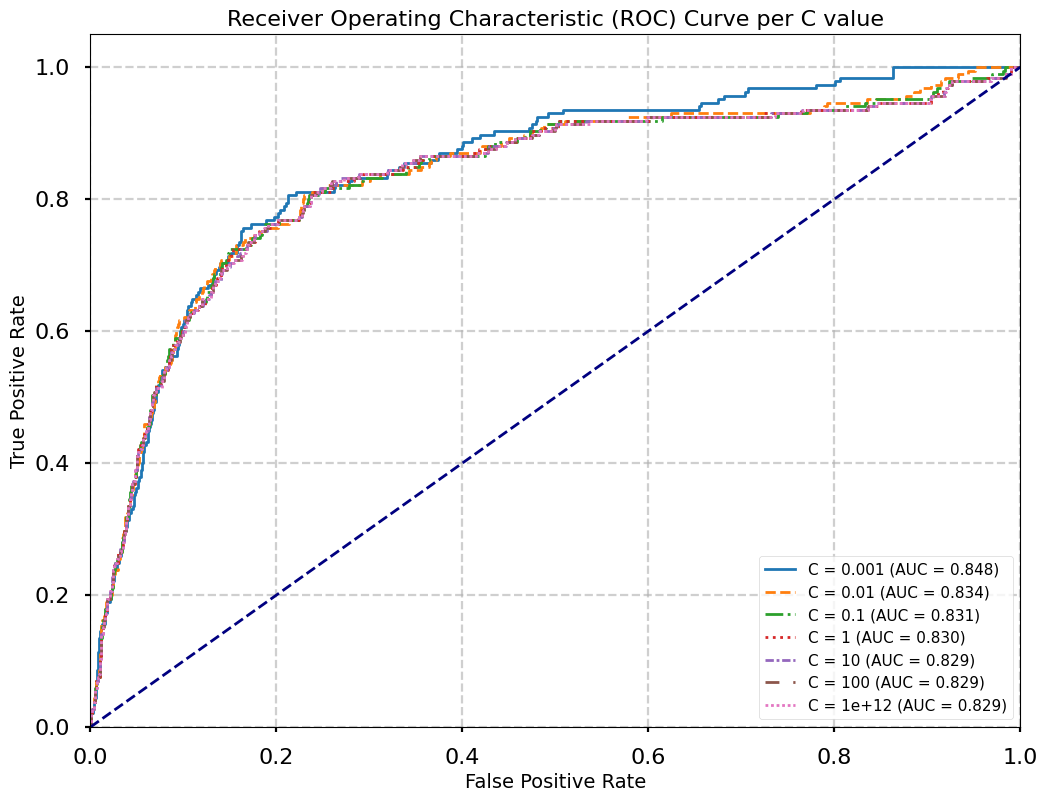

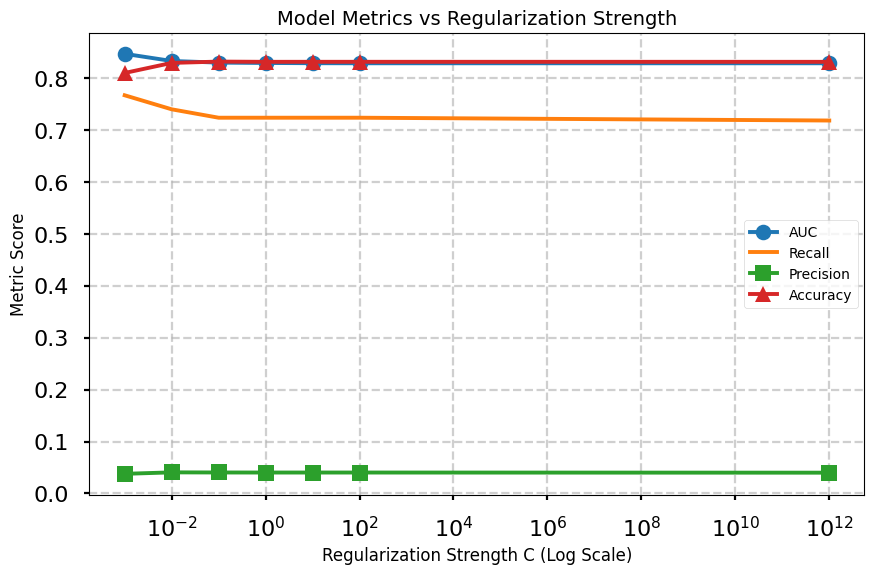

In [23]:

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1e12]
# Use names for labels, format the large number
names = [f"{c:.3g}" for c in C_param_range] # Format numbers nicely (e.g., 1e+12)
# Use a more distinct color palette and define line styles
colors = sns.color_palette('tab10', n_colors=len(C_param_range))
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 1))] # Different line styles

plt.figure(figsize=(12, 9)) # Slightly larger figure
AUCs =[]
recalls =[]
Accuracies=[]
precisions =[]

for n, c in enumerate(C_param_range):
    # Fit a model
    # Increased max_iter to potentially help with convergence warnings
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='sag', max_iter=1000)
    model_log = logreg.fit(X_train, y_train)
    # print(model_log) # Preview model params (optional, can be verbose)

    # Predict
    y_hat_test = logreg.predict(X_test)

    # Use decision_function for ROC curve scores
    # No need to refit, use the already fitted model_log
    y_score = model_log.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    A = auc(fpr, tpr)
    pre = precision_score(y_test, y_hat_test)
    rec = recall_score(y_test, y_hat_test)
    acc = accuracy_score(y_test, y_hat_test)

    # Print metrics (optional, keep if needed)
    print(f"--- C = {names[n]} ---")
    print(f'AUC: {A:.4f}')
    print(f"Precision Score: {pre:.4f}")
    print(f"Recall Score: {rec:.4f}")
    print(f"Accuracy Score: {acc:.4f}")
    print(f"F1 Score: {f1_score(y_test, y_hat_test):.4f}")
    print('-------------------------------------------------------')

    AUCs.append(A)
    precisions.append(pre)
    recalls.append(rec)
    Accuracies.append(acc)

    lw = 2
    plt.plot(fpr, tpr, color=colors[n % len(colors)], # Cycle through colors
             linestyle=linestyles[n % len(linestyles)], # Cycle through linestyles
             lw=lw,
             label=f'C = {names[n]} (AUC = {A:.3f})') # Simpler label with AUC

# Plot the baseline
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# Set limits and labels with larger fonts
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve per C value', fontsize=16)

# Remove manual ticks to let Matplotlib decide
# plt.yticks([i/20.0 for i in range(21)])
# plt.xticks([i/20.0 for i in range(21)])

# Add grid and legend with larger font
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right', fontsize=11)
plt.show()

# Optional: Plot summary metrics vs C (log scale for C)
plt.figure(figsize=(10, 6))
plt.semilogx(C_param_range, AUCs, marker='o', label='AUC')
plt.semilogx(C_param_range, recalls, marker='x', label='Recall')
plt.semilogx(C_param_range, precisions, marker='s', label='Precision')
plt.semilogx(C_param_range, Accuracies, marker='^', label='Accuracy')
plt.xlabel('Regularization Strength C (Log Scale)', fontsize=12)
plt.ylabel('Metric Score', fontsize=12)
plt.title('Model Metrics vs Regularization Strength', fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.6) # Grid for both major and minor ticks on log scale
plt.legend(fontsize=10)
plt.show()

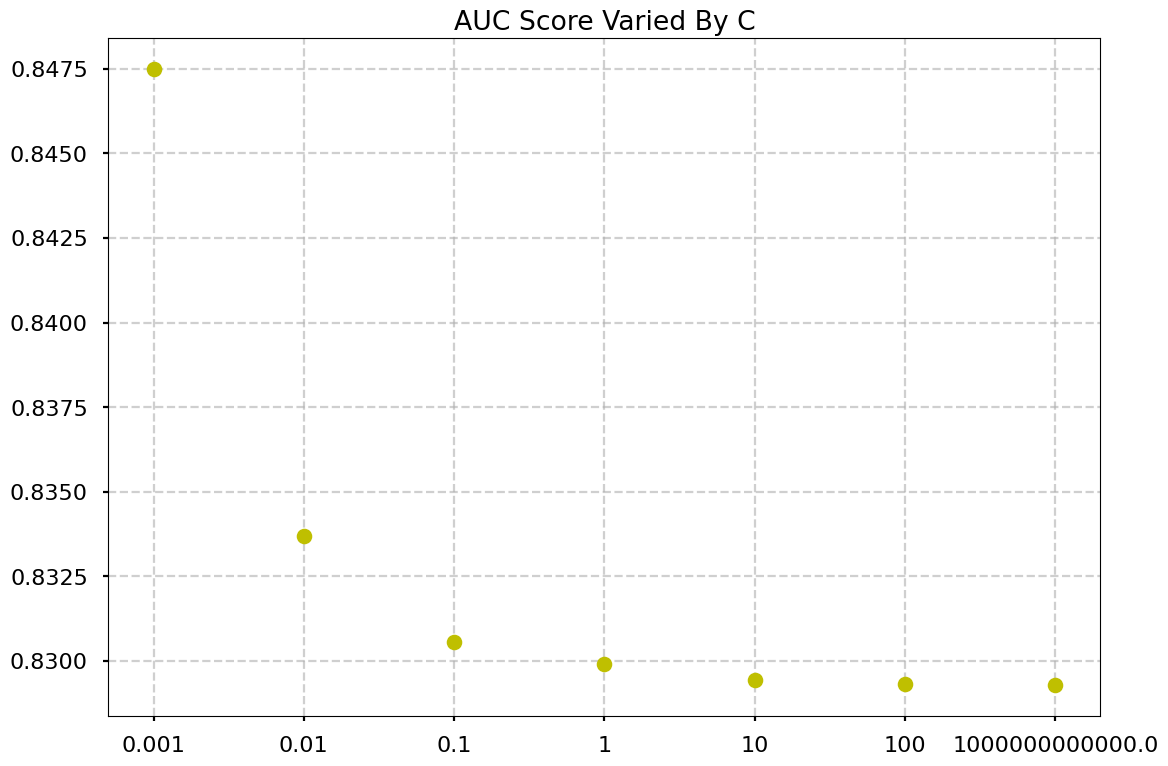

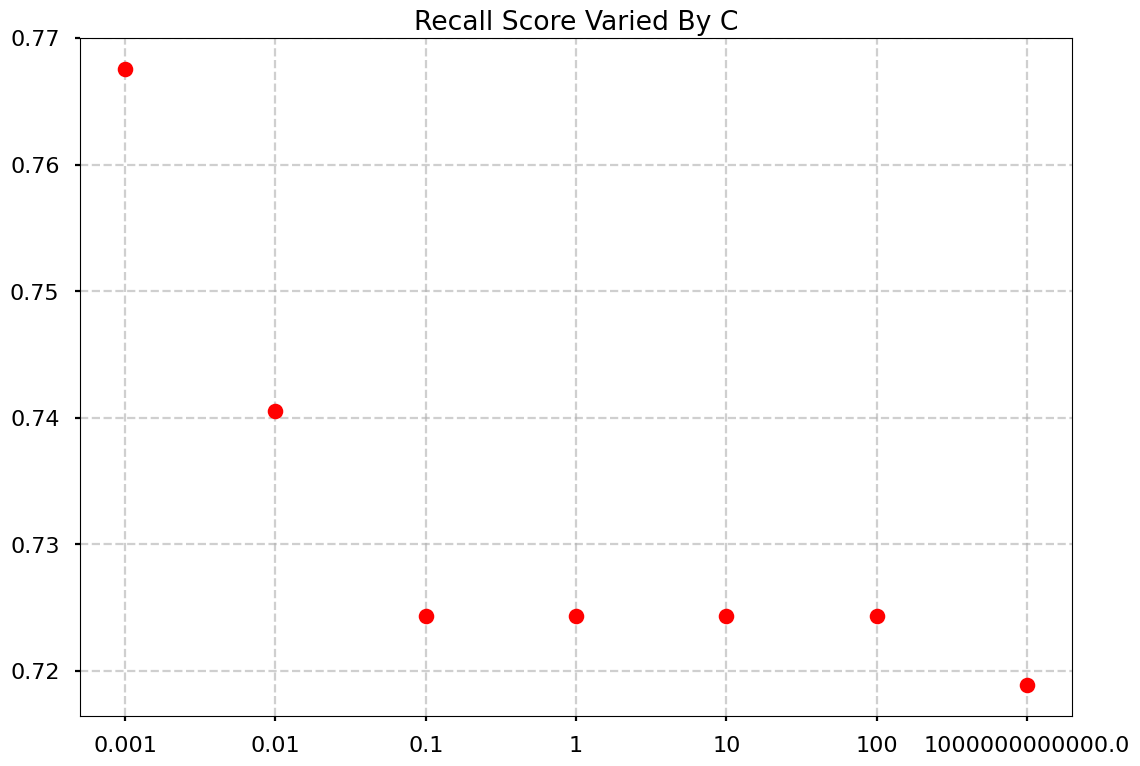

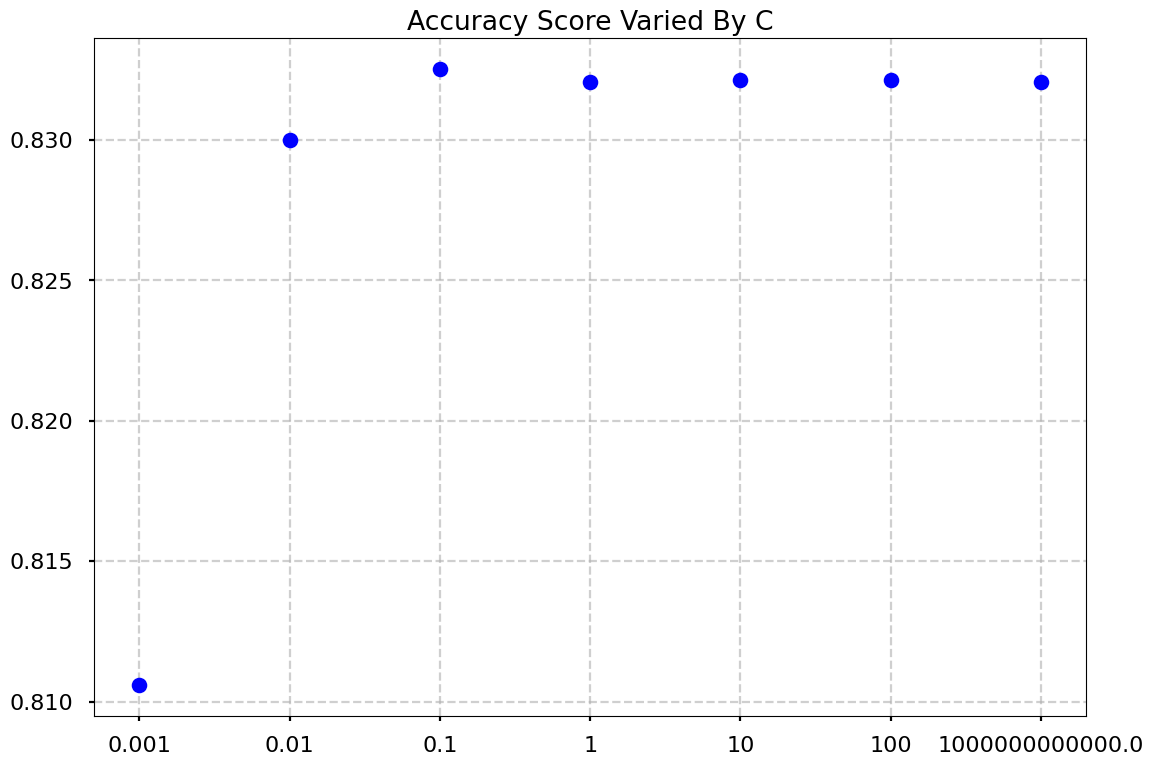

In [25]:
plt.plot(range(len(C_param_range)),AUCs,'yo')
plt.xticks(range(len(C_param_range)),C_param_range)
plt.title('AUC '+ 'score varied by C'.title())
plt.grid(True, linestyle='--', alpha=0.6) 
plt.show()

plt.plot(range(len(C_param_range)), recalls, 'ro')
plt.xticks(range(len(C_param_range)),C_param_range)
plt.title('Recall score varied by C'.title())
plt.grid(True, linestyle='--', alpha=0.6) 
plt.show()

plt.plot(range(len(C_param_range)), Accuracies,'bo')
plt.xticks(range(len(C_param_range)),C_param_range)
plt.title('accuracy score varied by C'.title())
plt.grid(True, linestyle='--', alpha=0.6) 
plt.show()

--- C = 1 ---
AUC: 0.8299
Precision Score: 0.0403
Recall Score: 0.7243
Accuracy Score: 0.8321
F1 Score: 0.0763
-------------------------------------------------------
--- C = 0.001 ---
AUC: 0.8475
Precision Score: 0.0378
Recall Score: 0.7676
Accuracy Score: 0.8106
F1 Score: 0.0720
-------------------------------------------------------
--- C = 0.0001 ---
AUC: 0.8590
Precision Score: 0.0339
Recall Score: 0.7892
Accuracy Score: 0.7827
F1 Score: 0.0650
-------------------------------------------------------
--- C = 0.0001 ---
AUC: 0.8590
Precision Score: 0.0339
Recall Score: 0.7892
Accuracy Score: 0.7827
F1 Score: 0.0650
-------------------------------------------------------
--- C = 1e-05 ---
AUC: 0.8550
Precision Score: 0.0313
Recall Score: 0.7730
Accuracy Score: 0.7687
F1 Score: 0.0601
-------------------------------------------------------


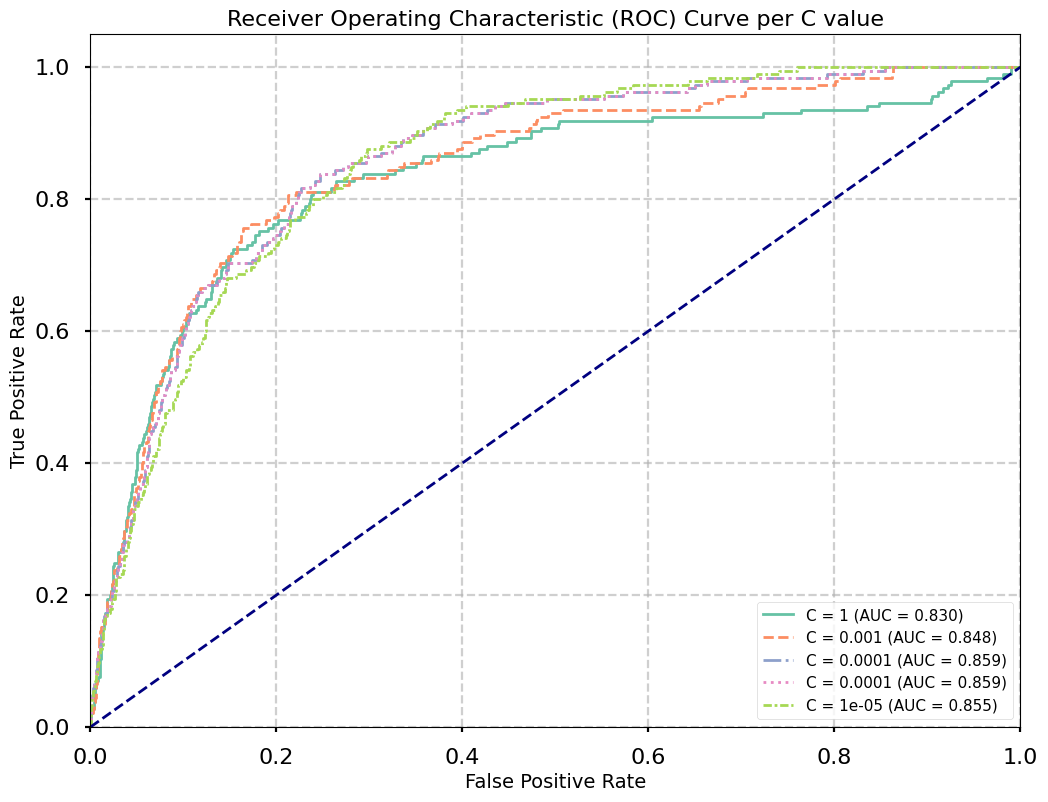

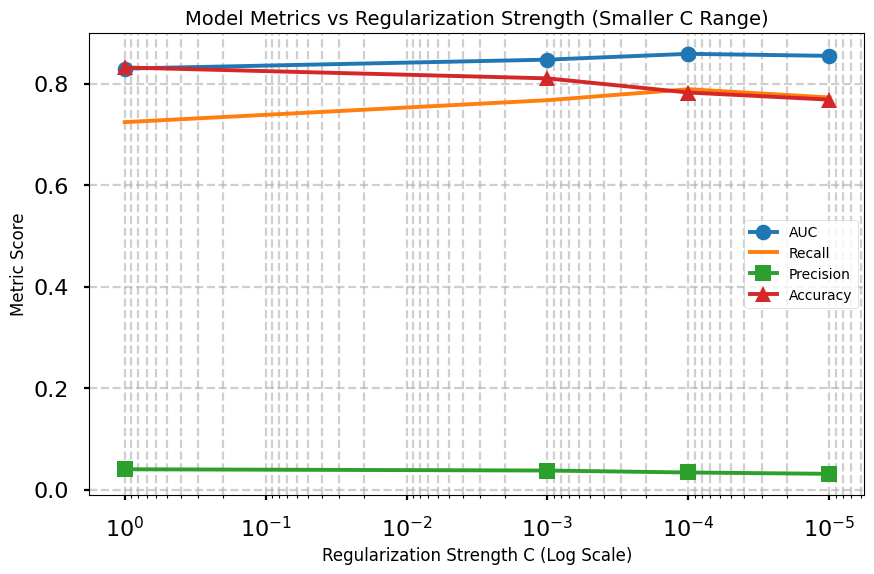

In [27]:
# In[34]

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [1, 0.001, 0.0001, 1e-4, 1e-5]
# Use names for labels, format the numbers
names = [f"{c:.1g}" for c in C_param_range] # Format numbers nicely (e.g., 1e-4)
# Use the requested color palette and define line styles
colors = sns.color_palette('Set2', n_colors=len(C_param_range))
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))] # Different line styles for 5 C values

plt.figure(figsize=(12, 9)) # Slightly larger figure
AUCs =[]
recalls =[]
Accuracies=[]
precisions =[]

for n, c in enumerate(C_param_range):
    # Fit a model
    # Increased max_iter to potentially help with convergence warnings
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='sag', max_iter=1000)
    model_log = logreg.fit(X_train, y_train)
    # print(model_log) # Preview model params (optional)

    # Predict
    y_hat_test = logreg.predict(X_test)

    # Use decision_function for ROC curve scores from the already fitted model
    y_score = model_log.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    A = auc(fpr, tpr)
    pre = precision_score(y_test, y_hat_test)
    rec = recall_score(y_test, y_hat_test)
    acc = accuracy_score(y_test, y_hat_test)

    # Print metrics (optional, keep if needed)
    print(f"--- C = {names[n]} ---")
    print(f'AUC: {A:.4f}')
    print(f"Precision Score: {pre:.4f}")
    print(f"Recall Score: {rec:.4f}")
    print(f"Accuracy Score: {acc:.4f}")
    print(f"F1 Score: {f1_score(y_test, y_hat_test):.4f}")
    print('-------------------------------------------------------')

    AUCs.append(A)
    precisions.append(pre)
    recalls.append(rec)
    Accuracies.append(acc)

    lw = 2
    plt.plot(fpr, tpr, color=colors[n % len(colors)], # Cycle through colors
             linestyle=linestyles[n % len(linestyles)], # Cycle through linestyles
             lw=lw,
             label=f'C = {names[n]} (AUC = {A:.3f})') # Simpler label with AUC

# Plot the baseline
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# Set limits and labels with larger fonts
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve per C value', fontsize=16)

# Remove manual ticks to let Matplotlib decide
# plt.yticks([i/20.0 for i in range(21)])
# plt.xticks([i/20.0 for i in range(21)])

# Add grid and legend with larger font
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right', fontsize=11)
plt.show()

# Optional: Plot summary metrics vs C (log scale for C) for this range
plt.figure(figsize=(10, 6))
plt.semilogx(C_param_range, AUCs, marker='o', label='AUC')
plt.semilogx(C_param_range, recalls, marker='x', label='Recall')
plt.semilogx(C_param_range, precisions, marker='s', label='Precision')
plt.semilogx(C_param_range, Accuracies, marker='^', label='Accuracy')
plt.xlabel('Regularization Strength C (Log Scale)', fontsize=12)
plt.ylabel('Metric Score', fontsize=12)
plt.title('Model Metrics vs Regularization Strength (Smaller C Range)', fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.6) # Grid for both major and minor ticks on log scale
plt.legend(fontsize=10)
# Invert x-axis because C values are decreasing
plt.gca().invert_xaxis()
plt.show()


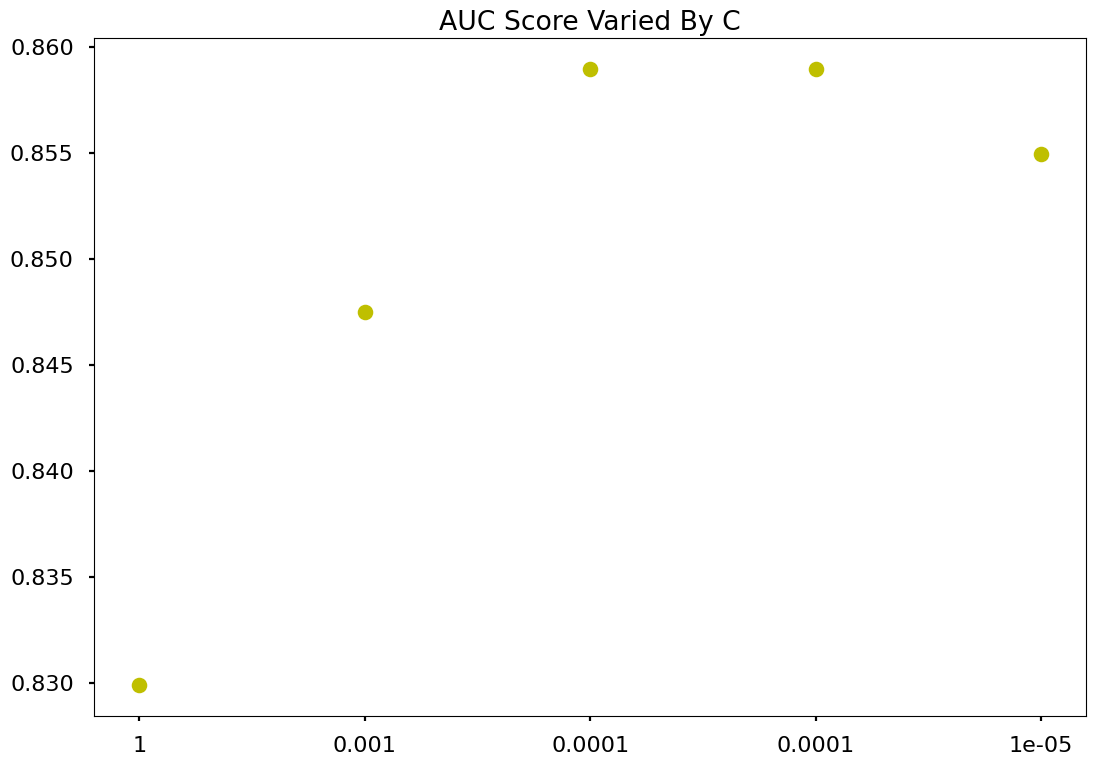

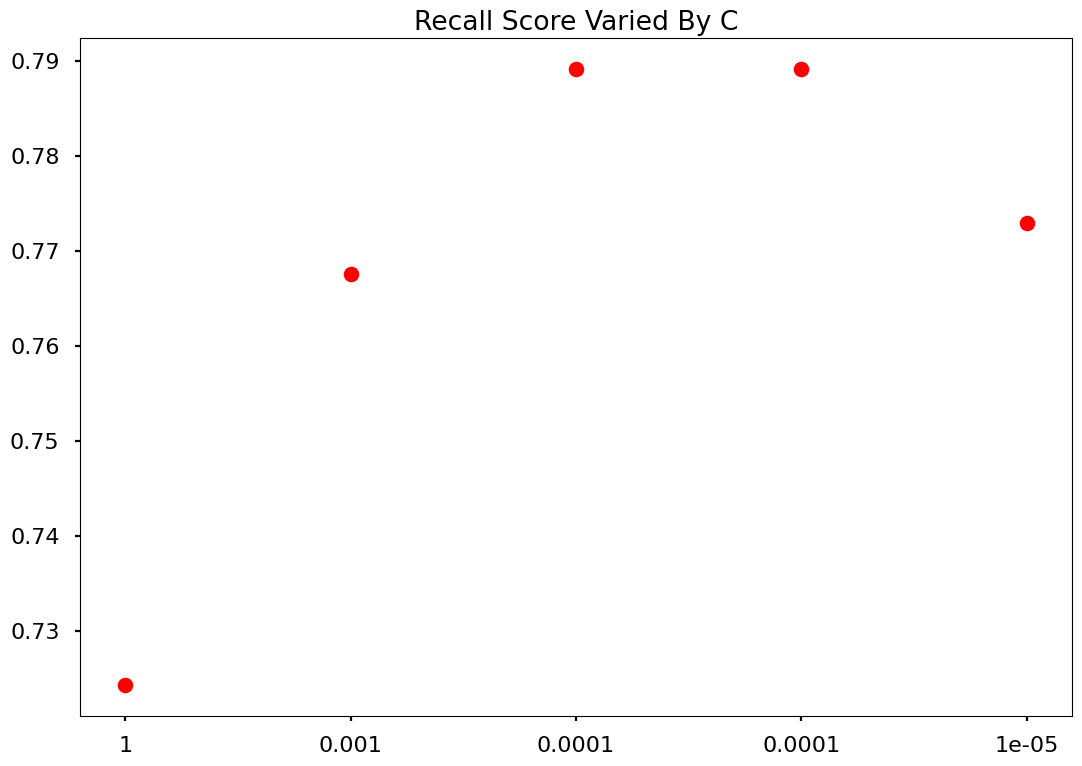

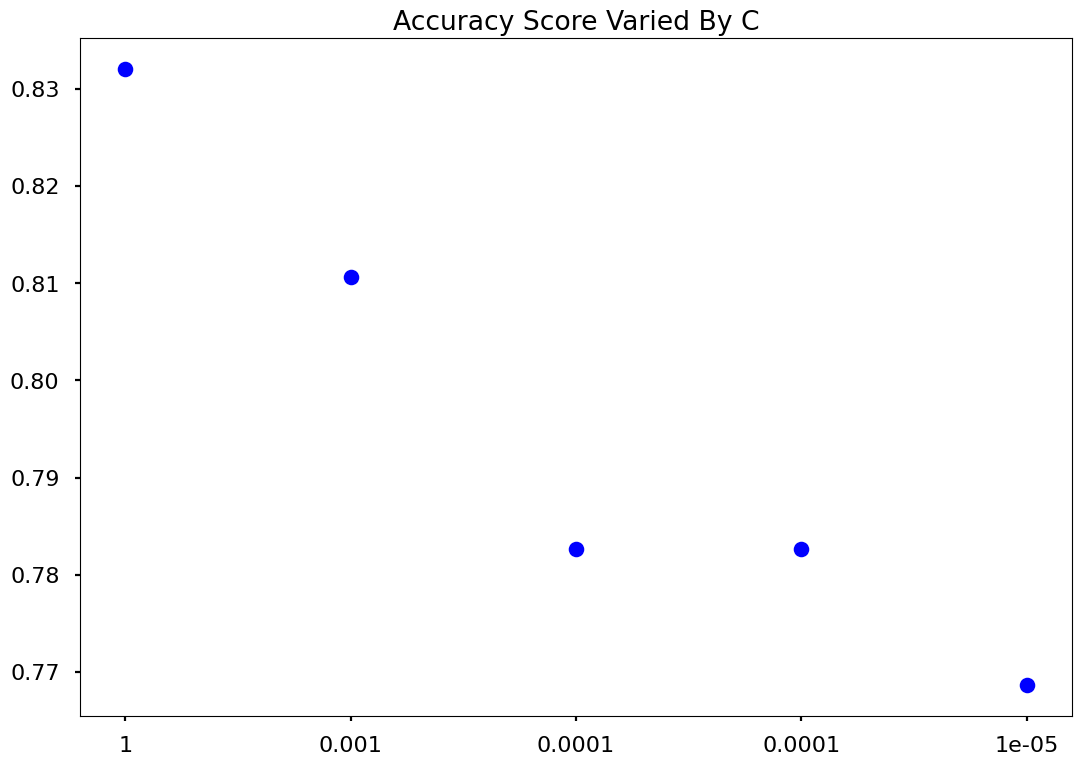

In [28]:
plt.plot(range(len(C_param_range)),AUCs,'yo')
plt.xticks(range(len(C_param_range)),C_param_range)
plt.title('AUC'+' score varied by C'.title())
plt.show()
plt.plot(range(len(C_param_range)), recalls, 'ro')
plt.xticks(range(len(C_param_range)),C_param_range)
plt.title('Recall score varied by C'.title())
plt.show()
plt.plot(range(len(C_param_range)), Accuracies,'bo') 
plt.xticks(range(len(C_param_range)),C_param_range)
plt.title('accuracy score varied by C'.title())
plt.show()

# Saving scores in a dataframe

Train set

Precision Score: 0.6200230398156815
Recall Score: 0.9084819073741955
Accuracy Score: 0.8391529682755733
F1 Score: 0.7370335501540568


Test set

Precision Score: 0.03776595744680851
Recall Score: 0.7675675675675676
Accuracy Score: 0.8105954782968596
F1 Score: 0.07198986058301647


Confusion matrix, without normalization
[[15526    43]
 [ 3618   142]]


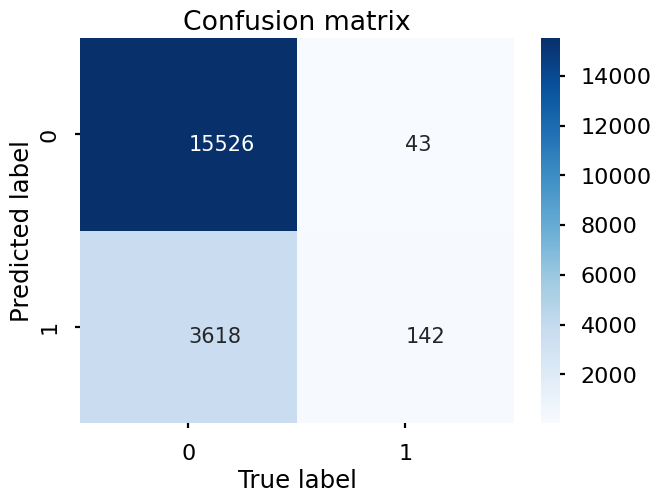

Log_reg is saved in Results table.
train_scores dataframe is updated.

         Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg         0.620023      0.908482        0.839153  0.737034


test_scores dataframe is updated.

         Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg         0.037766      0.767568        0.810595   0.07199

--- Running Random Forest ---
Train set

Precision Score: 1.0
Recall Score: 0.9999472518198123
Accuracy Score: 0.9999869123651973
F1 Score: 0.9999736252142951


Test set

Precision Score: 0.2803030303030303
Recall Score: 0.2
Accuracy Score: 0.9874282166692534
F1 Score: 0.2334384858044164


Confusion matrix, without normalization
[[19049   148]
 [   95    37]]


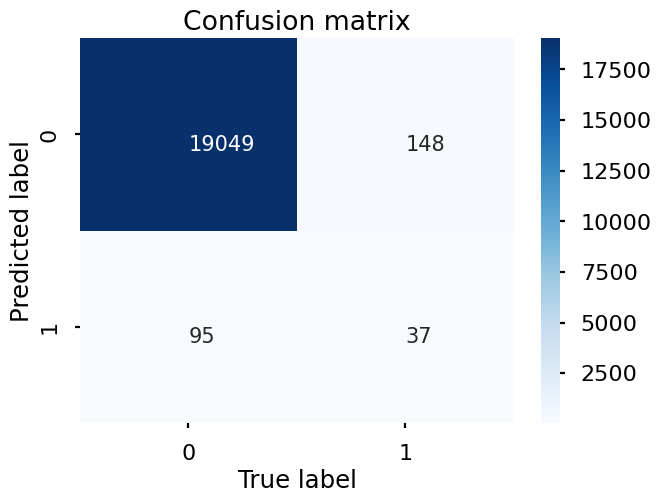

RandomForest is saved in Results table.
train_scores dataframe is updated.

              Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg              0.620023      0.908482        0.839153  0.737034
RandomForest         1.000000      0.999947        0.999987  0.999974


test_scores dataframe is updated.

              Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg              0.037766      0.767568        0.810595  0.071990
RandomForest         0.280303      0.200000        0.987428  0.233438

--- Running Gradient Boosting ---
Train set

Precision Score: 0.8882386749568943
Recall Score: 0.8967190631923199
Accuracy Score: 0.9463799602135902
F1 Score: 0.892458723784025


Test set

Precision Score: 0.11304347826086956
Recall Score: 0.4918918918918919
Accuracy Score: 0.958197527031921
F1 Score: 0.18383838383838383


Confusion matrix, without normalization
[[18430    94]
 [  714    91]]


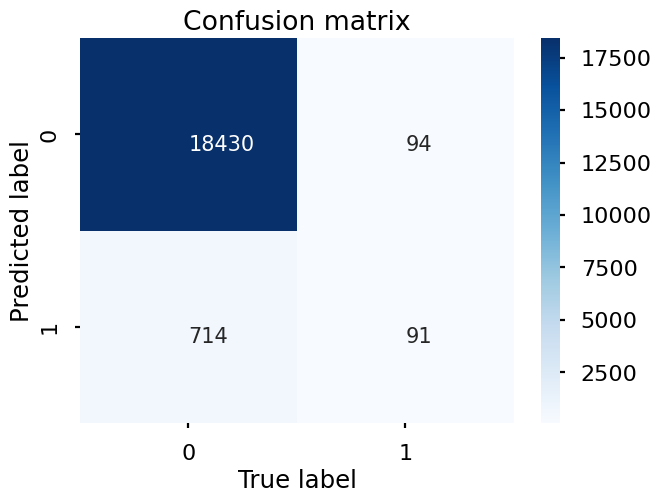

GradientBoosting is saved in Results table.
train_scores dataframe is updated.

                  Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg                  0.620023      0.908482        0.839153  0.737034
RandomForest             1.000000      0.999947        0.999987  0.999974
GradientBoosting         0.888239      0.896719        0.946380  0.892459


test_scores dataframe is updated.

                  Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg                  0.037766      0.767568        0.810595  0.071990
RandomForest             0.280303      0.200000        0.987428  0.233438
GradientBoosting         0.113043      0.491892        0.958198  0.183838


In [30]:
Log_reg = result()
logreg = LogisticRegression(fit_intercept=False, C=0.001, solver='sag')
Saving_results(Log_reg,logreg,'Log_reg')

# Add Random Forest
print("\n--- Running Random Forest ---")
Rnd_Forest = result() # Create a result object for Random Forest
# Instantiate the model (using default parameters here)
# Add n_estimators=100 for reproducibility and common practice, random_state for consistency
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
Saving_results(Rnd_Forest, rf_model, 'RandomForest') # Save results with name 'RandomForest'

# Add Gradient Boosting
print("\n--- Running Gradient Boosting ---")
Grad_Boost = result() # Create a result object for Gradient Boosting
# Instantiate the model (using default parameters here)
# Add n_estimators=100 and random_state for consistency
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
Saving_results(Grad_Boost, gb_model, 'GradientBoosting') # Save results with name 'GradientBoosting'


In [31]:
#This is the coefficients that defines the influence of each features to predict the target. 
Log_reg.params['coef_'][0]

array([ 0.01197106, -0.05410888, -0.25999912, -0.00821786,  0.0778559 ,
       -0.12817827, -0.0711136 , -0.13205292, -0.08012727,  0.01080889,
       -0.30803776,  0.24214212, -0.1077239 ,  0.49120801,  0.10477423,
       -0.08442838, -0.04415021, -0.36662801,  0.18773932,  0.24702206,
        0.45715273,  0.06258057, -0.08652722,  0.42009155, -0.25823444,
        0.01107987,  0.47376103,  0.09596301,  0.70420139,  0.05704412,
        0.25624172,  0.37015724,  0.20539824,  0.04084141,  0.12280395,
       -0.1345525 ,  0.25071693, -0.01487382,  0.18075036,  0.04995315,
        0.07732281])

# Feature Importance

In [32]:
#Create a dataframe with feature names and the coefficients
LogReg_FtImp = pd.DataFrame()
LogReg_FtImp['feature']=np.array(X_train.columns)
LogReg_FtImp['importance']= Log_reg.params['coef_'][0]

LogReg_FtImp['importance_abs'] = abs(LogReg_FtImp['importance'])#absolute values of coefficients to rank features' influences

LogReg_FtImp.sort_values(by=['importance_abs'],ascending=False, inplace=True)
LogReg_FtImp.reset_index(inplace=True)

LogReg_FtImp.drop(['index'],axis=1, inplace=True)

In [33]:
LogReg_FtImp

,feature,importance,importance_abs
0,mode_cat_Grocery,0.704201,0.704201
1,avg_cp_use_cust,0.491208,0.491208
2,brand_type_Established,0.473761,0.473761
3,ct_cp_use_cust,0.457153,0.457153
4,sum_cp_used,0.420092,0.420092
5,mode_cat_Pharmaceutical,0.370157,0.370157
6,ct_items,-0.366628,0.366628
7,sum_cp_dis,-0.308038,0.308038
8,sum_total_dis,-0.259999,0.259999
9,sum_oth_dis,-0.258234,0.258234


In [34]:
#Pick top 10
set(LogReg_FtImp.feature[:10])

{'avg_cp_use_cust',
 'brand_type_Established',
 'ct_cp_use_cust',
 'ct_items',
 'mode_cat_Grocery',
 'mode_cat_Pharmaceutical',
 'sum_cp_dis',
 'sum_cp_used',
 'sum_oth_dis',
 'sum_total_dis'}

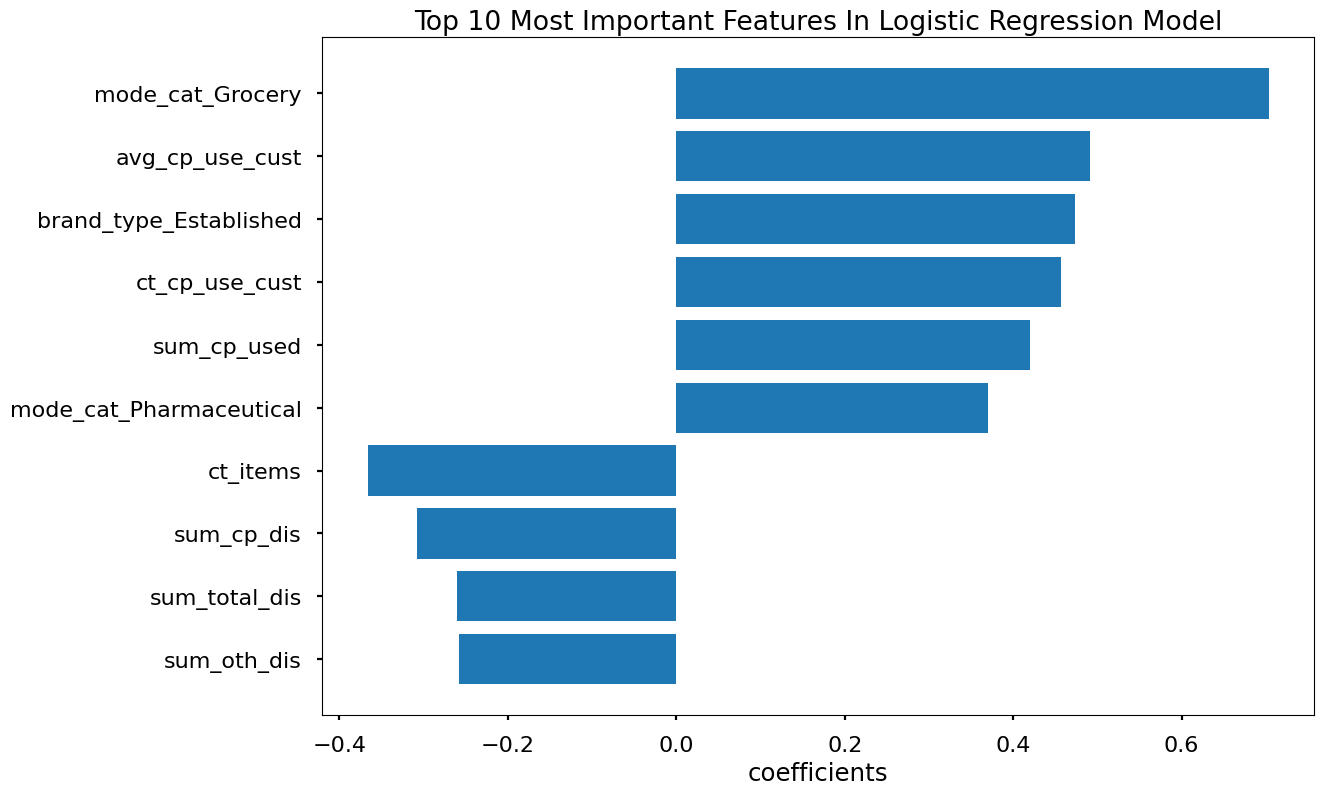

In [35]:
fig, ax = plt.subplots()
feat_imp = LogReg_FtImp.importance[:10]
ax.barh(np.arange(len(feat_imp)),feat_imp,align ='center')
ax.set_yticks(np.arange(len(feat_imp)))
ax.set_yticklabels(LogReg_FtImp.feature[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('coefficients')
ax.set_title('Top 10 most important features in logistic regression model'.title())

plt.show()

# Saving the model results to Results dictionary

In [36]:
Results['LogReg_FtImp']=LogReg_FtImp

# Random Forest

In [37]:

randForest= RandomForestClassifier( max_depth=5, n_estimators=100)

In [38]:

randForest.__dict__

{'estimator': DecisionTreeClassifier(),
 'n_estimators': 100,
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'random_state',
  'ccp_alpha',
  'monotonic_cst'),
 'bootstrap': True,
 'oob_score': False,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'monotonic_cst': None,
 'ccp_alpha': 0.0}

In [39]:
randForest.fit(X_train,y_train)
y_hat_train = randForest.predict(X_train)
y_hat_test = randForest.predict(X_test)

Model Report

Accuracy :0.9083603811119254
AUC Score (Train):0.9667411549932511
CV Score : Mean - 0.9663058740831978 | Std - 0.0016834784755067104 | Min - 0.9638135160642348 | Max - 0.9681598279466805


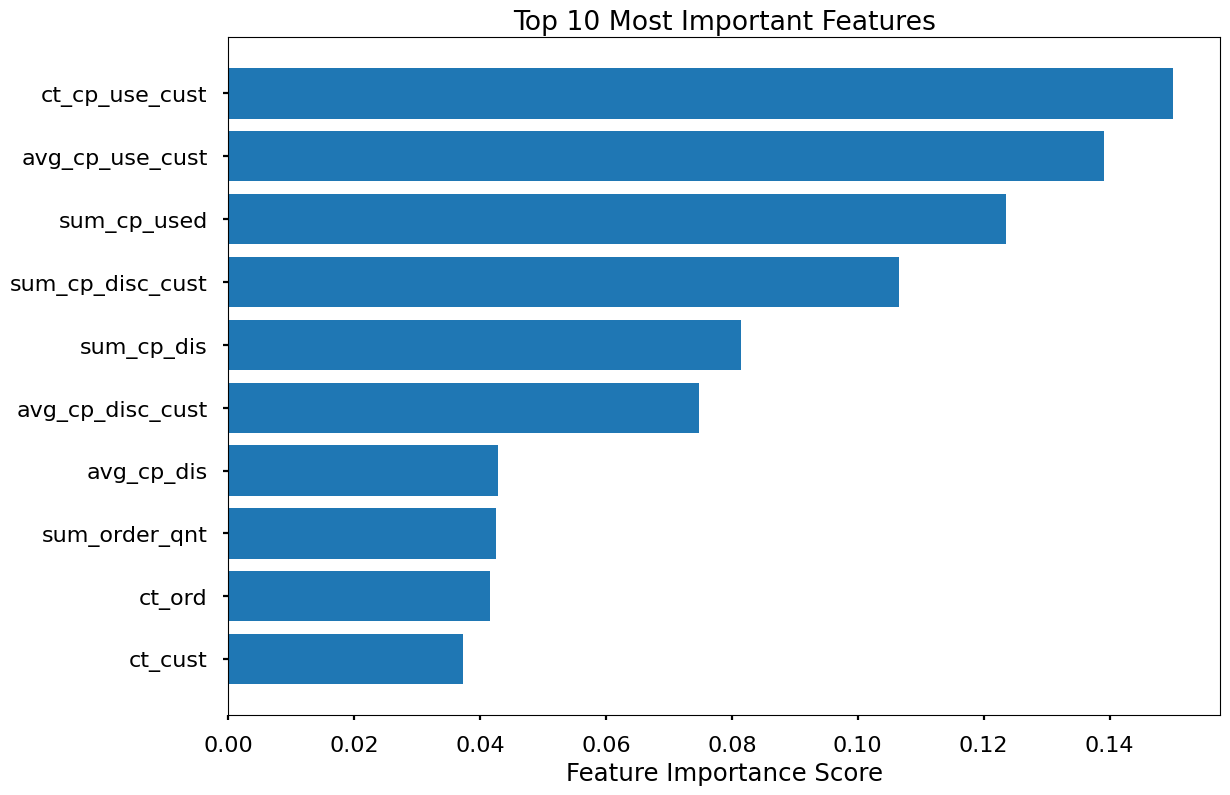

In [40]:
modelfit(randForest, X_train, y_train, X_train.columns)

In [41]:
print_metrics(y_hat_train,y_hat_test)

Train set

Precision Score: 0.808297938464726
Recall Score: 0.8231353518303619
Accuracy Score: 0.9076798241021883
F1 Score: 0.8156491741584779


Test set

Precision Score: 0.08621960206337509
Recall Score: 0.6324324324324324
Accuracy Score: 0.9323296600962284
F1 Score: 0.1517509727626459




Confusion matrix, without normalization
[[17904    68]
 [ 1240   117]]


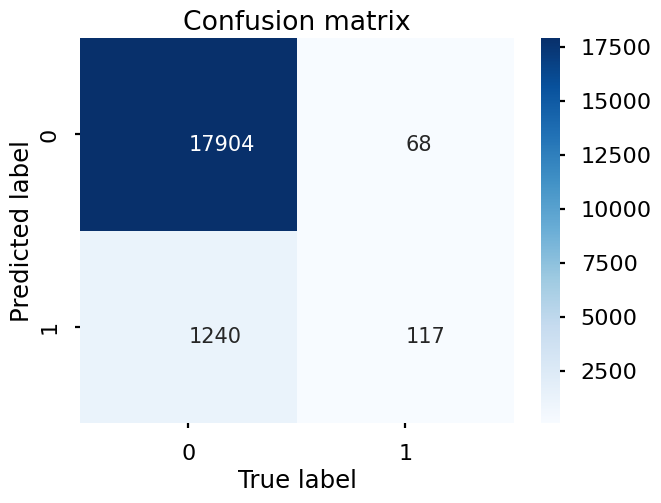

array([[17904,    68],
       [ 1240,   117]])

In [42]:
plot_confusion_matrix(y_hat_test)

# Tuning hyper-parameters individually

### Max_depth

In [43]:
X_train.shape

(76408, 41)

In [44]:

[2*x+1 for x in range(0,21)]

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41]

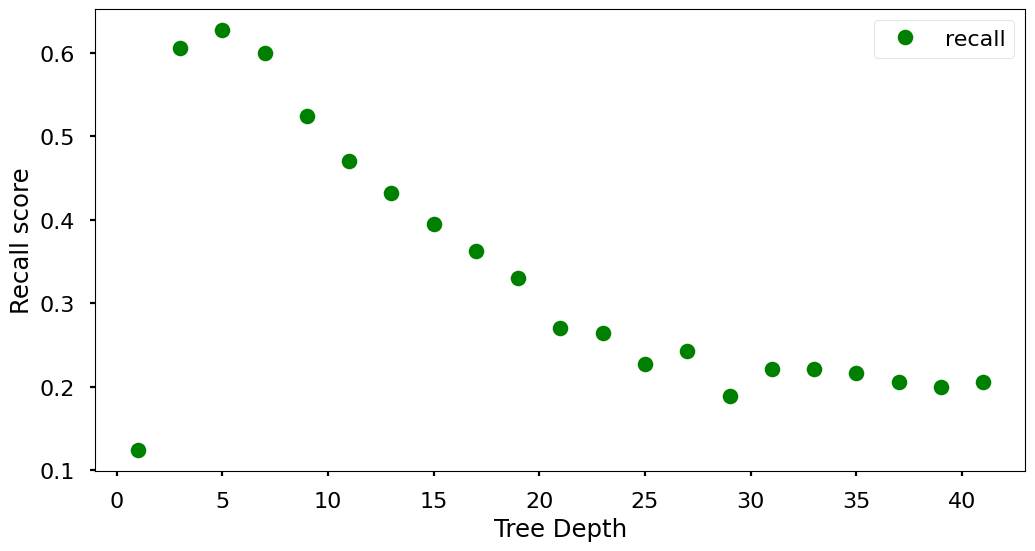

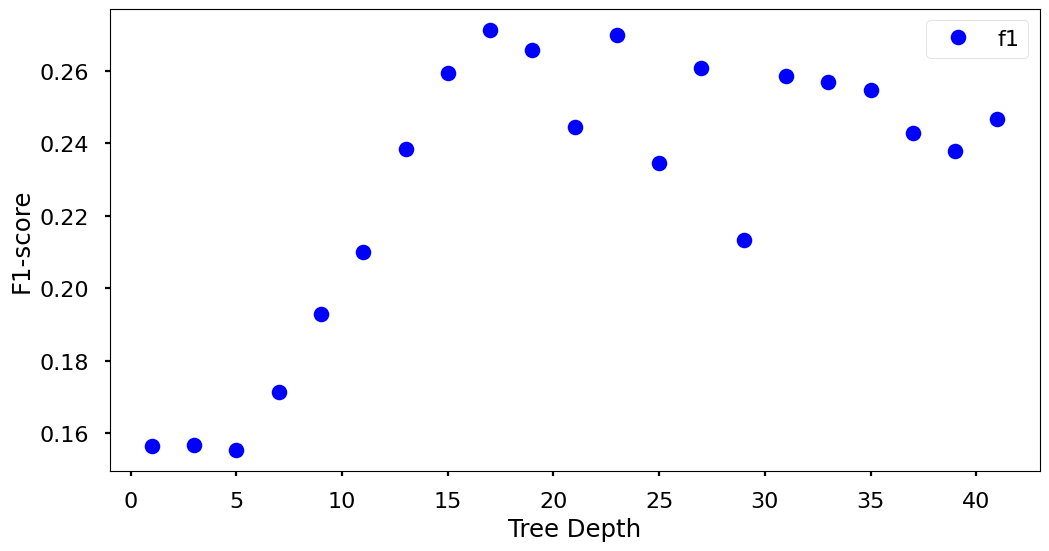

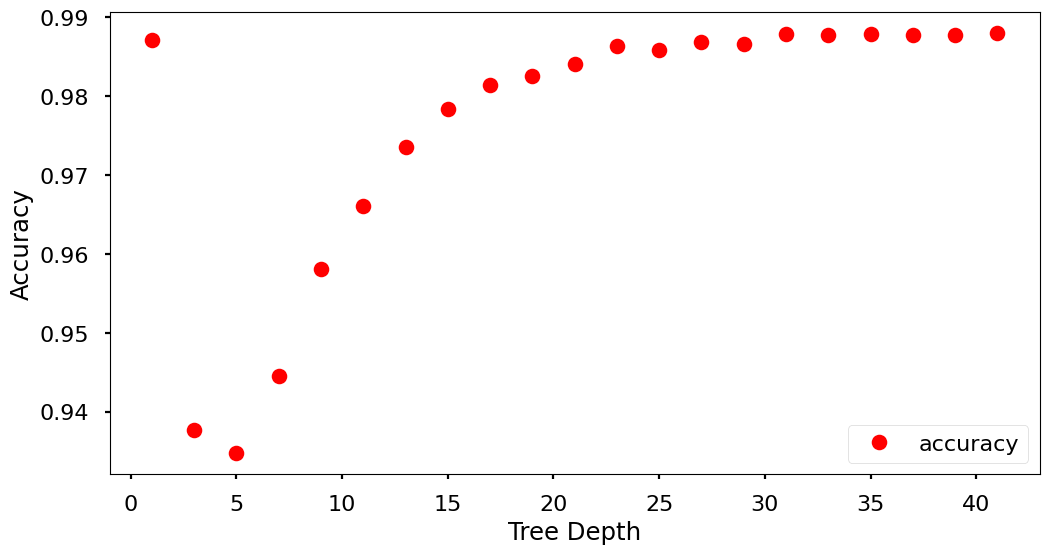

In [45]:

max_depths = [2*x+1 for x in range(0,21)]
# evaluation scores saved in lists
accuracy_results = []
f1_results = []
recall_results=[]

for max_depth in max_depths:
    forest = RandomForestClassifier(max_depth = max_depth, n_estimators =100, random_state=123)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)
    
    f1 = f1_score(y_test, y_pred)
    f1_results.append(f1)
    
    rec = recall_score(y_test, y_pred)
    recall_results.append(rec)
    
plt.figure(figsize =(12,6))
plt.plot(max_depths, recall_results,'go', label='recall')
plt.xlabel('Tree Depth')
plt.ylabel('Recall score')
plt.legend()
plt.show()

    
plt.figure(figsize =(12,6))
plt.plot(max_depths, f1_results,'bo', label='f1')
plt.xlabel('Tree Depth')
plt.ylabel('F1-score')
plt.legend()
plt.show()

plt.figure(figsize = (12,6))
plt.plot(max_depths, accuracy_results,'ro', label = 'accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [46]:
#dataframe of the evaluation scores with the max_depth as its index
search_max_depths = pd.DataFrame(index = max_depths)
search_max_depths['accuracy']= accuracy_results
search_max_depths['f1_score'] =f1_results
search_max_depths['recall_score'] = recall_results

search_max_depths

,accuracy,f1_score,recall_score
1,0.987170,0.156463,0.124324
3,0.937658,0.156753,0.605405
5,0.934761,0.155392,0.627027
7,0.944488,0.171429,0.600000
9,0.958042,0.193035,0.524324
11,0.966113,0.209891,0.470270
13,0.973563,0.238450,0.432432
15,0.978426,0.259325,0.394595
17,0.981375,0.271255,0.362162
19,0.982565,0.265795,0.329730


In [47]:
#save the df in a dictionary 
rndforest_tuning={}
rndforest_tuning['search_max_depths'] = search_max_depths

### min_samples_split

In [48]:
[int(x*0.01*len(X_train)) for x in np.arange(1,10,2)]

[764, 2292, 3820, 5348, 6876]

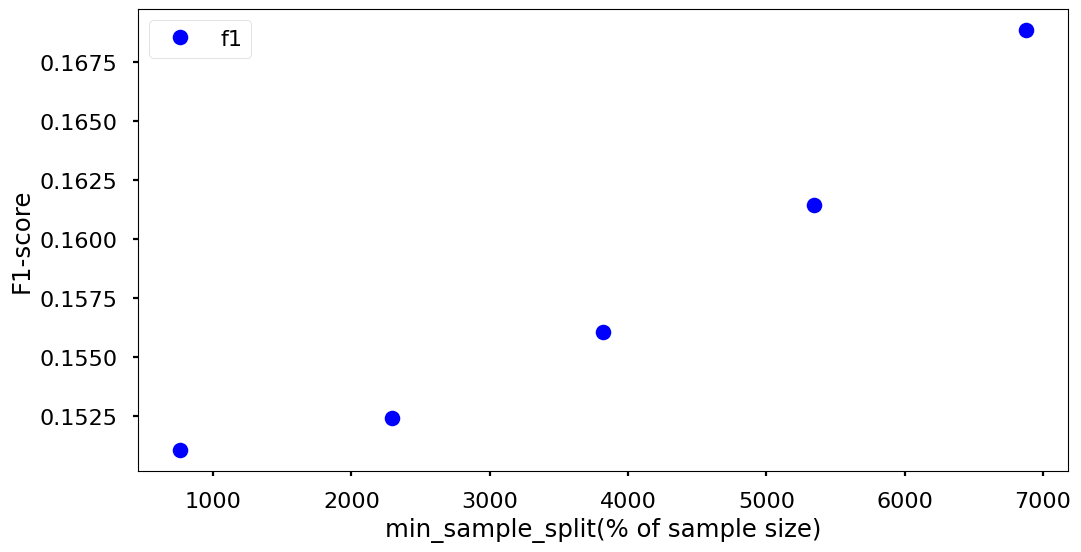

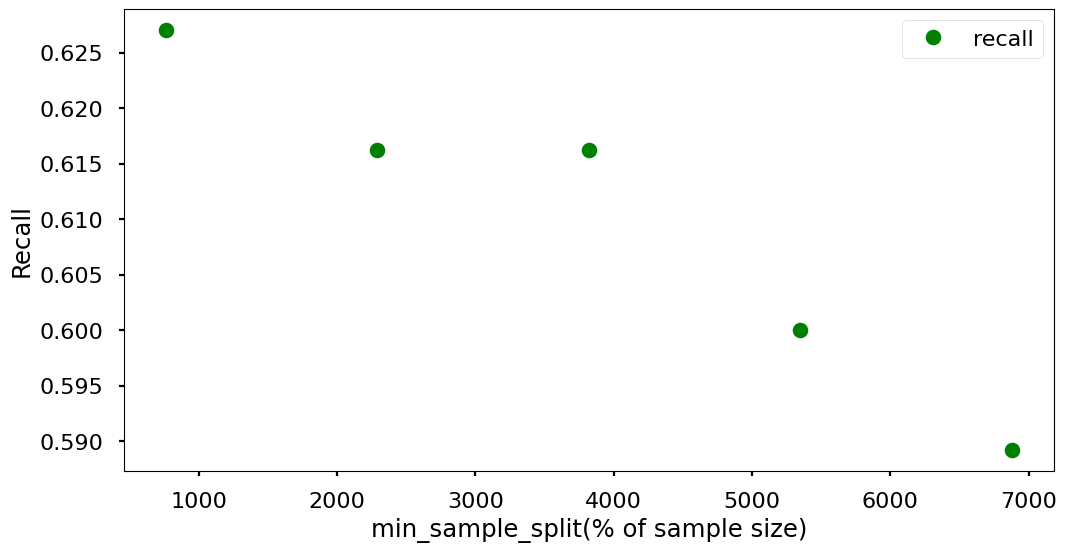

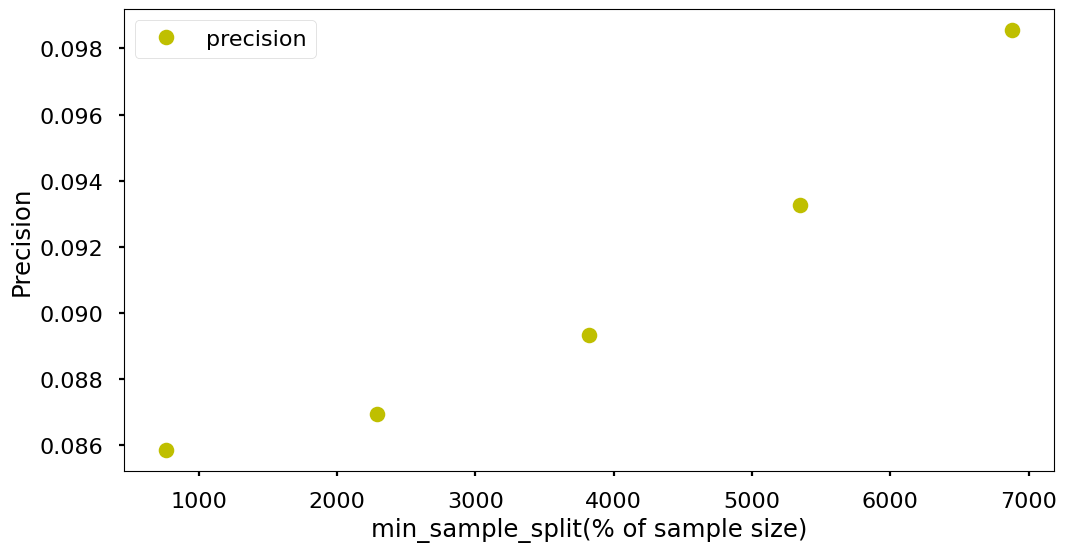

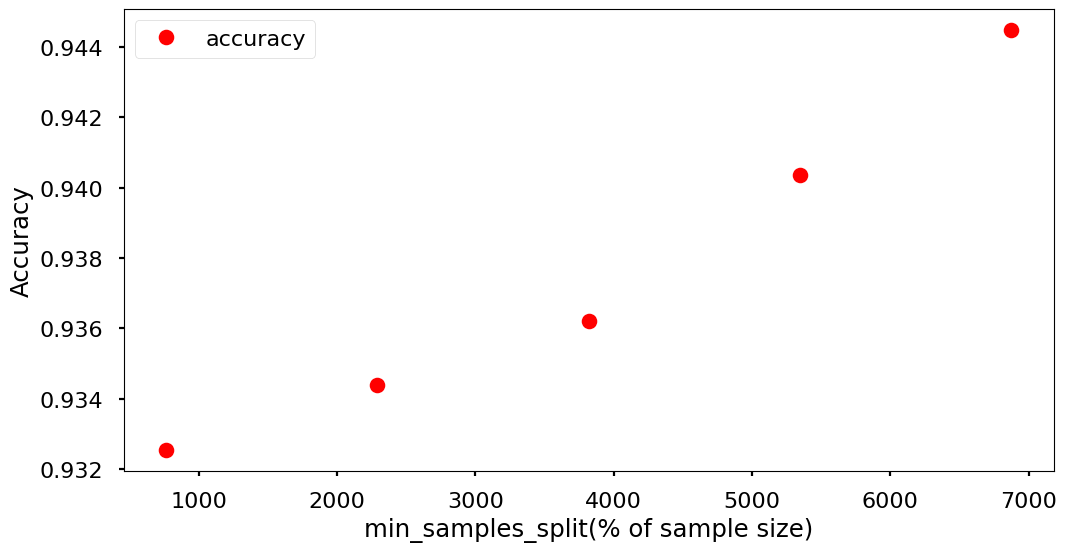

In [49]:

min_samples_splits =[int(x*0.01*len(X_train)) for x in np.arange(1,10,2)]
accuracy_results = []
f1_results = []
recall_results = []
precision_results=[]

for min_samples_split in min_samples_splits:
    forest = RandomForestClassifier(max_depth=5,min_samples_split = min_samples_split, n_estimators =100,random_state=123)
    forest.fit(X_train, y_train)
    
    y_pred = forest.predict(X_test)
    
    recall = recall_score(y_test,y_pred)
    recall_results.append(recall)
    
    precision = precision_score(y_test,y_pred)
    precision_results.append(precision)
    
    f1 = f1_score(y_test, y_pred)
    f1_results.append(f1)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)
    
plt.figure(figsize =(12,6))
plt.plot(min_samples_splits, f1_results,'bo', label='f1')
plt.xlabel('min_sample_split(% of sample size)')
plt.ylabel('F1-score')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_splits, recall_results,'go', label='recall')
plt.xlabel('min_sample_split(% of sample size)')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_splits, precision_results,'yo', label='precision')
plt.xlabel('min_sample_split(% of sample size)')
plt.ylabel('Precision')
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(min_samples_splits, accuracy_results,'ro', label = 'accuracy')
plt.xlabel('min_samples_split(% of sample size)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
search_min_samples_split = pd.DataFrame(index = min_samples_splits)
search_min_samples_split['accuracy']= accuracy_results
search_min_samples_split['f1_score'] =f1_results
search_min_samples_split['recall_score'] = recall_results

search_min_samples_split

,accuracy,f1_score,recall_score
764,0.932537,0.151042,0.627027
2292,0.934399,0.152406,0.616216
3820,0.936210,0.156057,0.616216
5348,0.940349,0.161455,0.600000
6876,0.944488,0.168861,0.589189


In [51]:
[int(x*0.001*len(X_train)) for x in range(1,11)]

[76, 152, 229, 305, 382, 458, 534, 611, 687, 764]

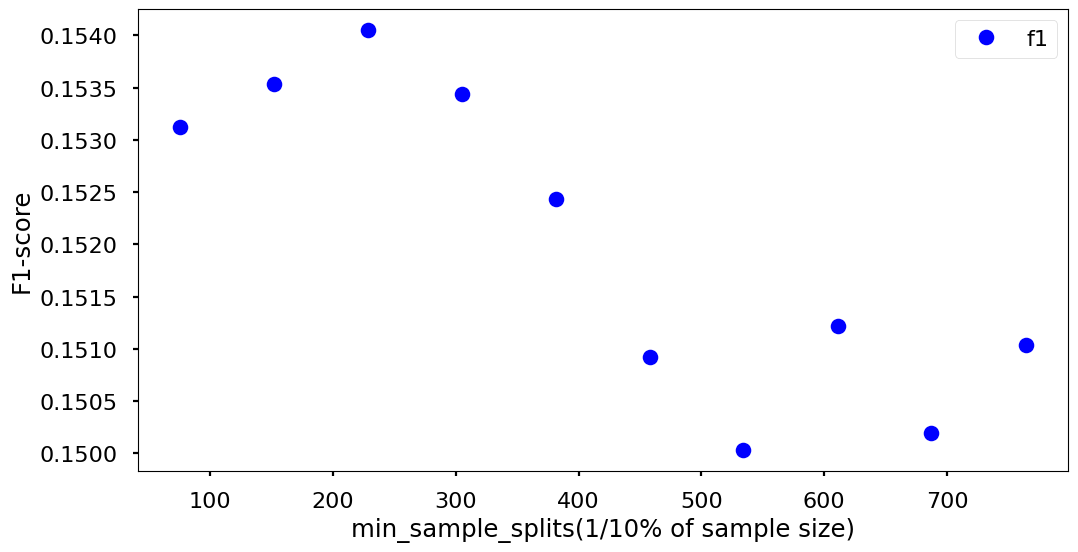

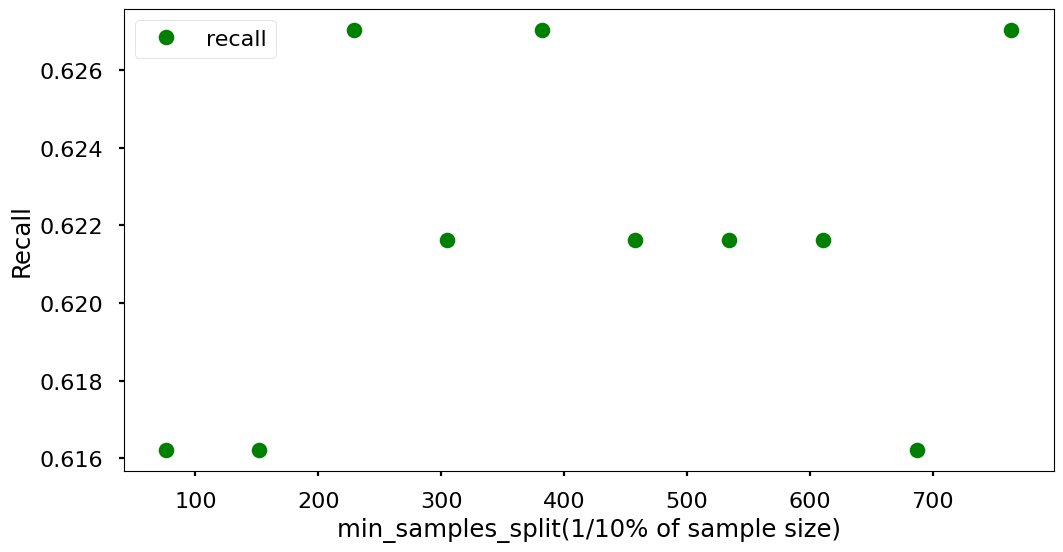

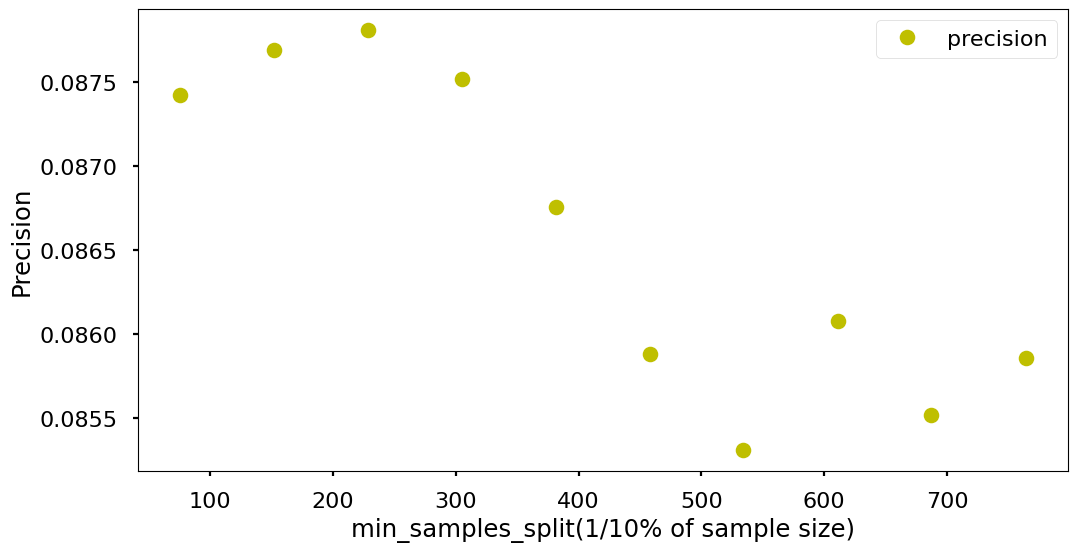

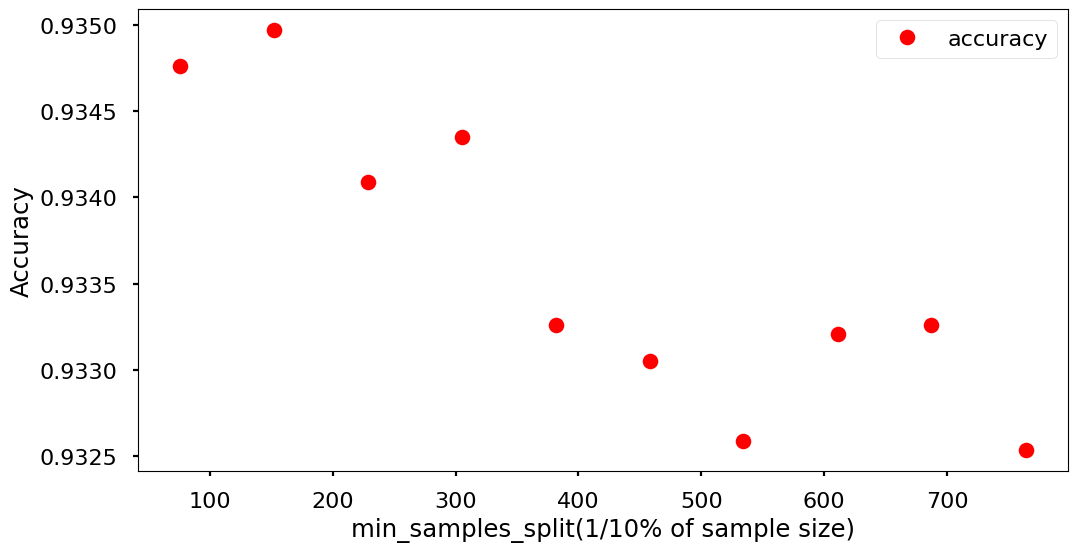

In [52]:
min_samples_splits =[int(x*0.001*len(X_train)) for x in range(1,11)]
accuracy_results = []
f1_results = []
recall_results = []
precision_results=[]

for min_samples_split in min_samples_splits:
    forest = RandomForestClassifier( max_depth=5, min_samples_split = min_samples_split, n_estimators =100,random_state=123)
    forest.fit(X_train, y_train)
    
    y_pred = forest.predict(X_test)
    
    recall = recall_score(y_test,y_pred)
    recall_results.append(recall)
    
    precision = precision_score(y_test,y_pred)
    precision_results.append(precision)
    
    f1 = f1_score(y_test, y_pred)
    f1_results.append(f1)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)
    
plt.figure(figsize =(12,6))
plt.plot(min_samples_splits, f1_results,'bo', label='f1')
plt.xlabel('min_sample_splits(1/10% of sample size)')
plt.ylabel('F1-score')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_splits, recall_results,'go', label='recall')
plt.xlabel('min_samples_split(1/10% of sample size)')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_splits, precision_results,'yo', label='precision')
plt.xlabel('min_samples_split(1/10% of sample size)')
plt.ylabel('Precision')
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(min_samples_splits, accuracy_results,'ro', label = 'accuracy')
plt.xlabel('min_samples_split(1/10% of sample size)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
search_min_samples_split2 = pd.DataFrame(index = min_samples_splits)
search_min_samples_split2['accuracy']= accuracy_results
search_min_samples_split2['f1_score'] =f1_results
search_min_samples_split2['recall_score'] = recall_results

search_min_samples_split2

,accuracy,f1_score,recall_score
76,0.934761,0.153123,0.616216
152,0.934968,0.153535,0.616216
229,0.934089,0.154050,0.627027
305,0.934347,0.153436,0.621622
382,0.933261,0.152431,0.627027
458,0.933054,0.150919,0.621622
534,0.932588,0.150033,0.621622
611,0.933209,0.151216,0.621622
687,0.933261,0.150198,0.616216
764,0.932537,0.151042,0.627027


In [55]:
# search_min_samples_split = search_min_samples_split2.append(search_min_samples_split) # Old, removed method
search_min_samples_split = pd.concat([search_min_samples_split2, search_min_samples_split]) # Use pd.concat instead

In [56]:
search_min_samples_split

,accuracy,f1_score,recall_score
76,0.934761,0.153123,0.616216
152,0.934968,0.153535,0.616216
229,0.934089,0.154050,0.627027
305,0.934347,0.153436,0.621622
382,0.933261,0.152431,0.627027
458,0.933054,0.150919,0.621622
534,0.932588,0.150033,0.621622
611,0.933209,0.151216,0.621622
687,0.933261,0.150198,0.616216
764,0.932537,0.151042,0.627027


In [58]:
search_min_samples_split.loc[[534,611,687]]

,accuracy,f1_score,recall_score
534,0.932588,0.150033,0.621622
611,0.933209,0.151216,0.621622
687,0.933261,0.150198,0.616216


In [59]:

rndforest_tuning['search_min_samples_split'] = search_min_samples_split

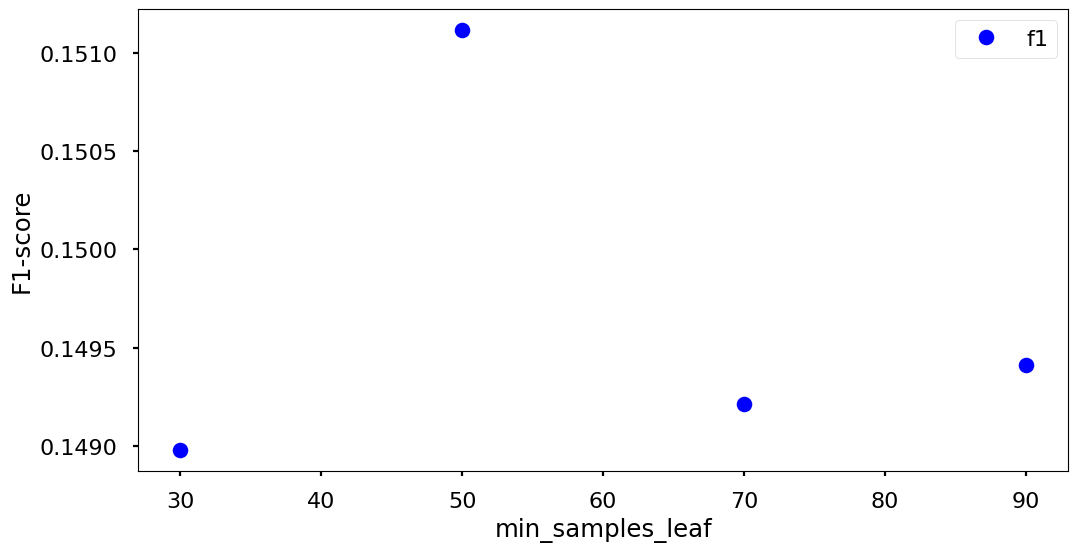

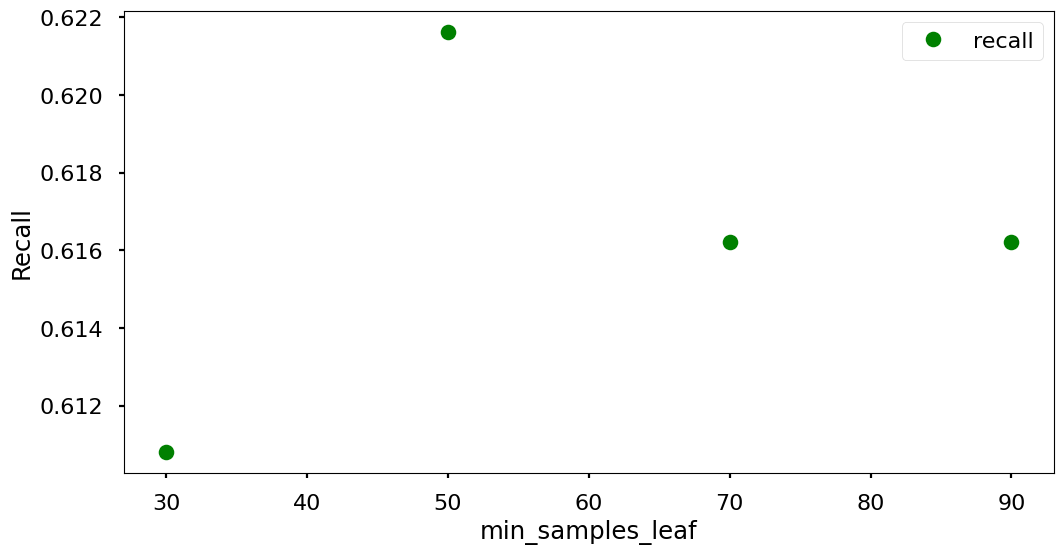

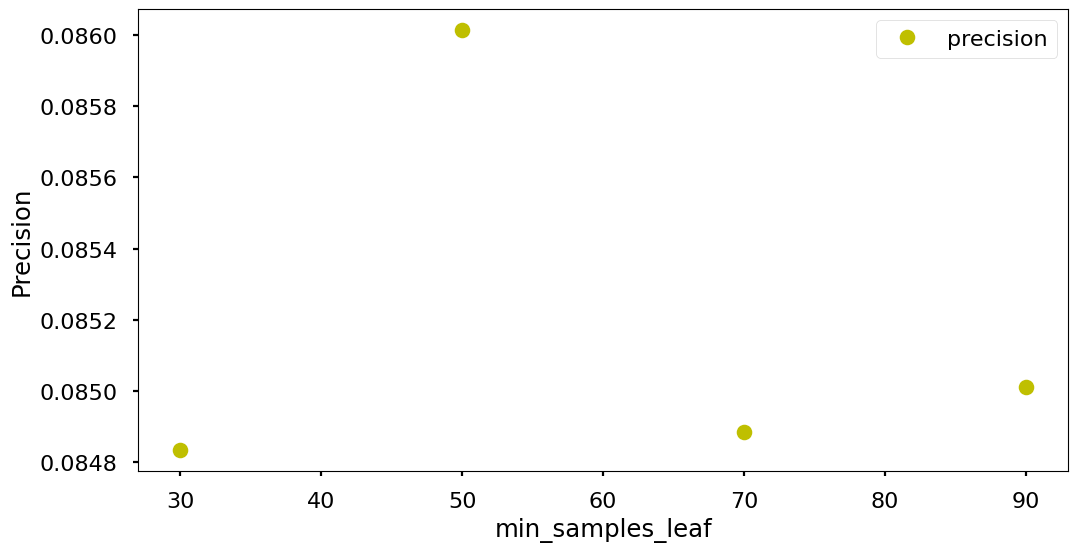

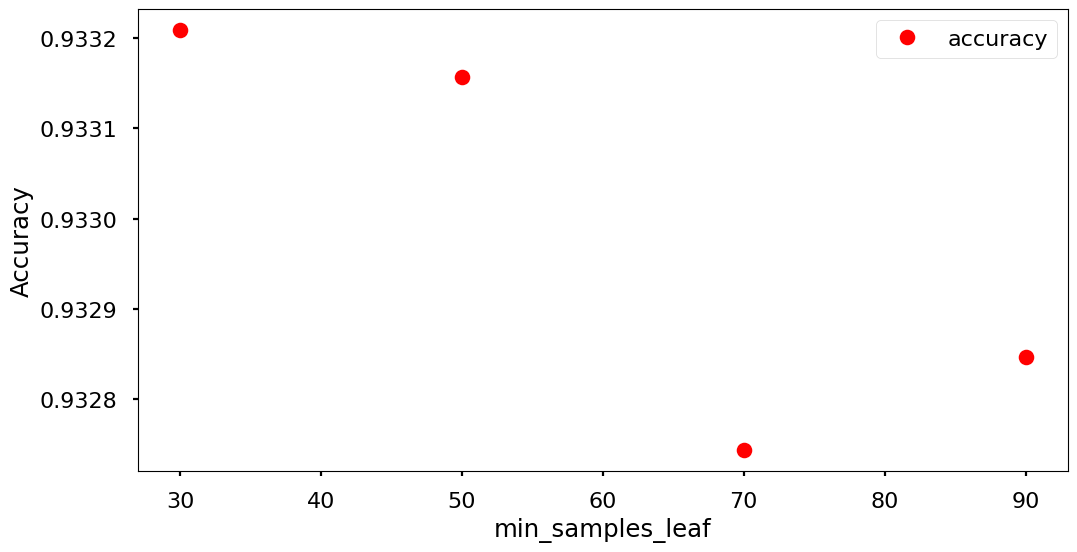

In [60]:
min_samples_leafs =[30,50,70,90]
accuracy_results = []
f1_results = []
recall_results = []
precision_results=[]

for min_samples_leaf in min_samples_leafs:
    forest = RandomForestClassifier( max_depth=5,
                                    min_samples_split=686,
                                    min_samples_leaf = min_samples_leaf,
                                    n_estimators =100,
                                    random_state=123)
    forest.fit(X_train, y_train)
    
    y_pred = forest.predict(X_test)
    
    recall = recall_score(y_test,y_pred)
    recall_results.append(recall)
    
    precision = precision_score(y_test,y_pred)
    precision_results.append(precision)
    
    f1 = f1_score(y_test, y_pred)
    f1_results.append(f1)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, f1_results,'bo', label='f1')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1-score')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, recall_results,'go', label='recall')
plt.xlabel('min_samples_leaf')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, precision_results,'yo', label='precision')
plt.xlabel('min_samples_leaf')
plt.ylabel('Precision')
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(min_samples_leafs, accuracy_results,'ro', label = 'accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [61]:
search_min_samples_leaf = pd.DataFrame(index = min_samples_leafs)
search_min_samples_leaf['accuracy']= accuracy_results
search_min_samples_leaf['f1_score'] =f1_results
search_min_samples_leaf['recall_score'] = recall_results

search_min_samples_leaf

,accuracy,f1_score,recall_score
30,0.933209,0.148978,0.610811
50,0.933157,0.151117,0.621622
70,0.932744,0.149215,0.616216
90,0.932847,0.149410,0.616216


In [62]:

[5*x for x in range(1,7)]

[5, 10, 15, 20, 25, 30]

In [67]:
min_samples_leafs =[5*x for x in range(1,7)]


for min_samples_leaf in min_samples_leafs:
    forest = RandomForestClassifier( max_depth=5,
                                    min_samples_split=687,
                                    min_samples_leaf = min_samples_leaf,
                                    n_estimators =100,
                                    random_state=123)
    forest.fit(X_train, y_train)
    
    y_pred = forest.predict(X_test)
    
    recall = recall_score(y_test,y_pred)
    recall_results.append(recall)
    
    precision = precision_score(y_test,y_pred)
    precision_results.append(precision)
    
    f1 = f1_score(y_test, y_pred)
    f1_results.append(f1)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)

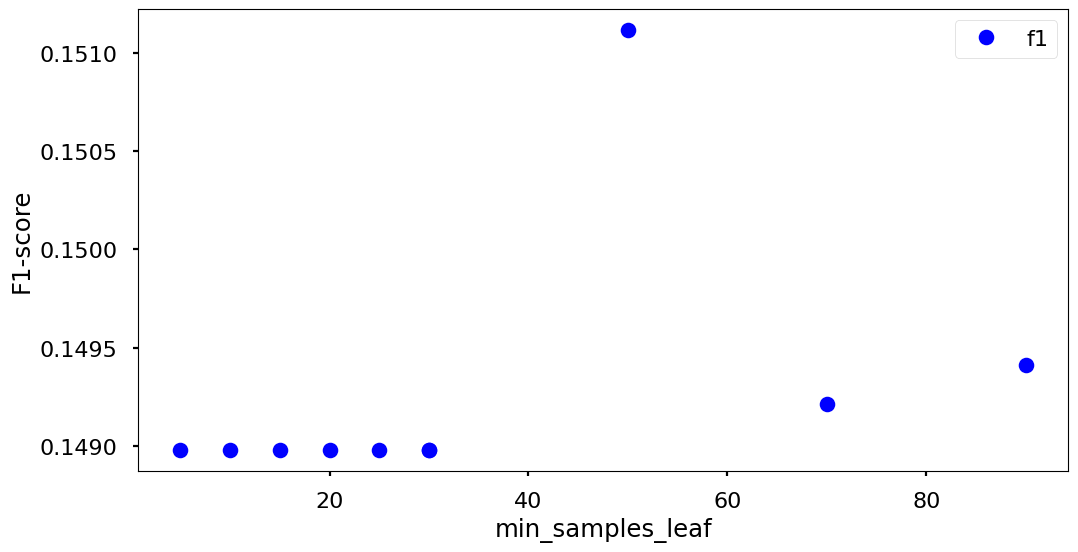

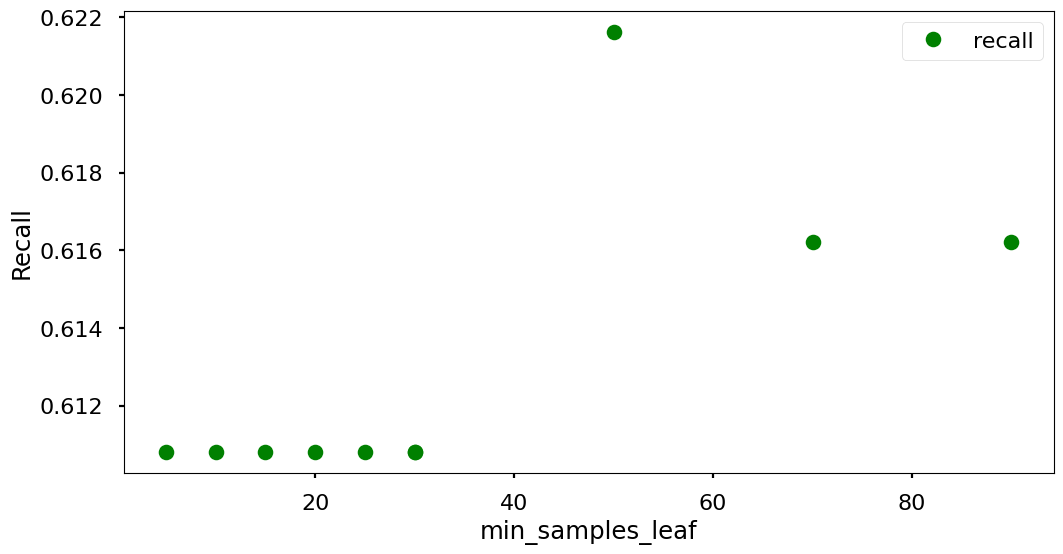

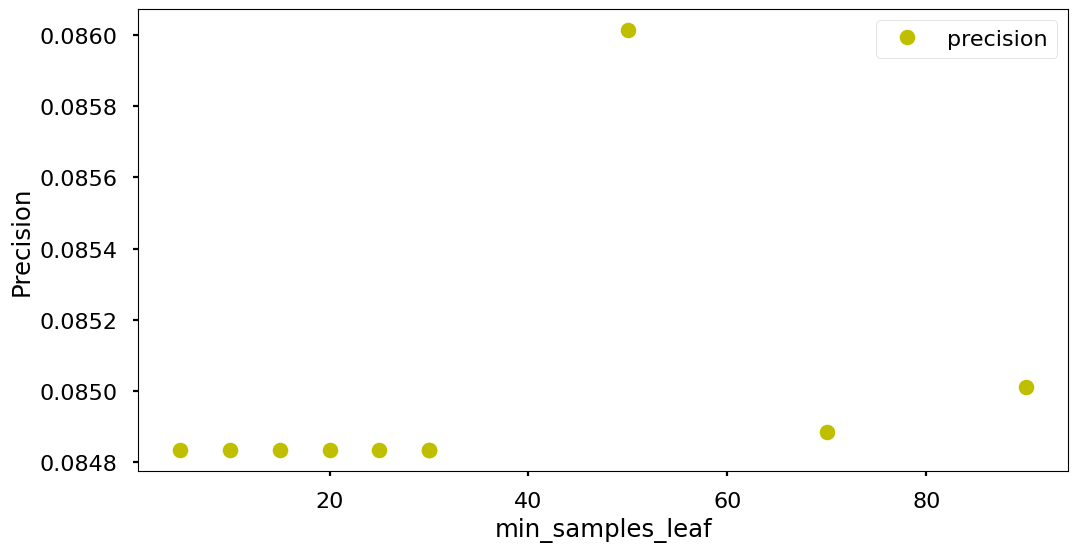

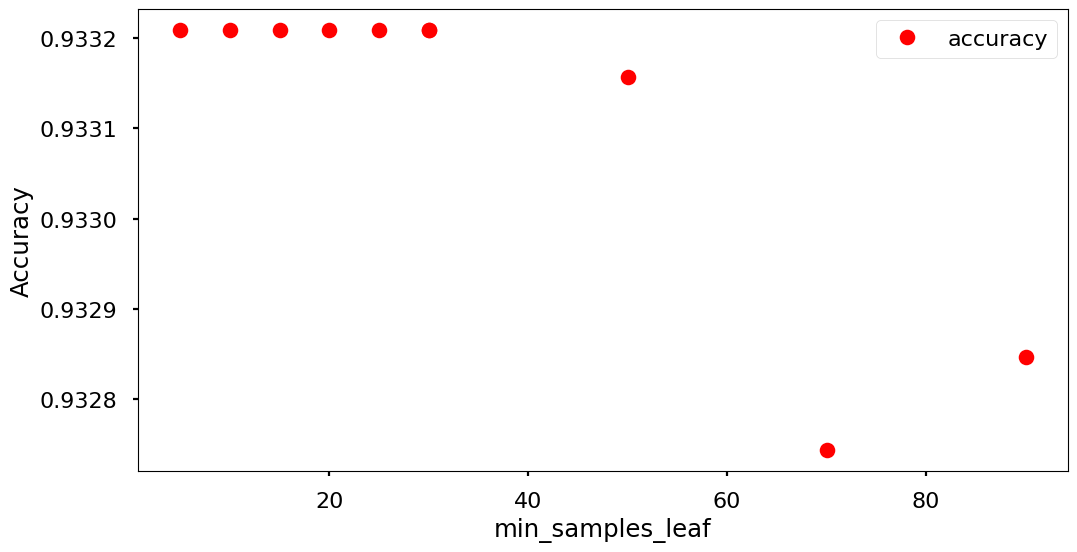

In [68]:
min_samples_leafs =[30,50,70,90]+[5*x for x in range(1,7)]

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, f1_results[:10],'bo', label='f1')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1-score')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, recall_results[:10],'go', label='recall')
plt.xlabel('min_samples_leaf')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, precision_results[:10],'yo', label='precision')
plt.xlabel('min_samples_leaf')
plt.ylabel('Precision')
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(min_samples_leafs, accuracy_results[:10],'ro', label = 'accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [69]:
search_min_samples_leaf = pd.DataFrame()
search_min_samples_leaf['min_samples_leaf']= min_samples_leafs
search_min_samples_leaf['accuracy']= accuracy_results[:10]
search_min_samples_leaf['f1_score'] =f1_results[:10]
search_min_samples_leaf['recall_score'] = recall_results[:10]

search_min_samples_leaf

,min_samples_leaf,accuracy,f1_score,recall_score
0,30,0.933209,0.148978,0.610811
1,50,0.933157,0.151117,0.621622
2,70,0.932744,0.149215,0.616216
3,90,0.932847,0.149410,0.616216
4,5,0.933209,0.148978,0.610811
5,10,0.933209,0.148978,0.610811
6,15,0.933209,0.148978,0.610811
7,20,0.933209,0.148978,0.610811
8,25,0.933209,0.148978,0.610811
9,30,0.933209,0.148978,0.610811


In [70]:
min_samples_leafs =[90 +30*x for x in range(0,6)]


for min_samples_leaf in min_samples_leafs:
    forest = RandomForestClassifier( max_depth=5,
                                    min_samples_split=687,
                                    min_samples_leaf = min_samples_leaf,
                                    n_estimators =100,
                                    random_state=123)
    forest.fit(X_train, y_train)
    
    y_pred = forest.predict(X_test)
    
    recall = recall_score(y_test,y_pred)
    recall_results.append(recall)
    
    precision = precision_score(y_test,y_pred)
    precision_results.append(precision)
    
    f1 = f1_score(y_test, y_pred)
    f1_results.append(f1)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)

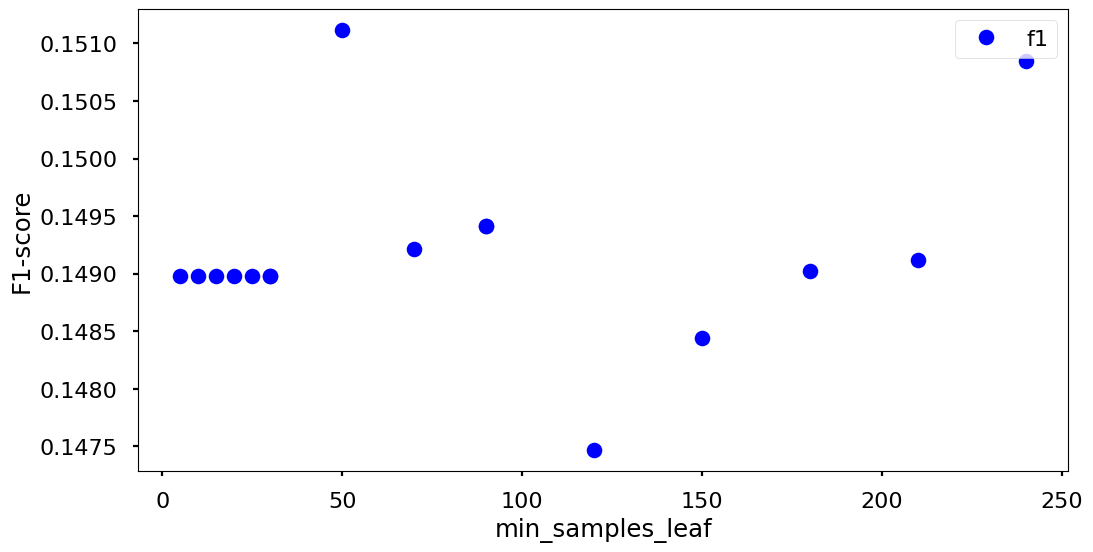

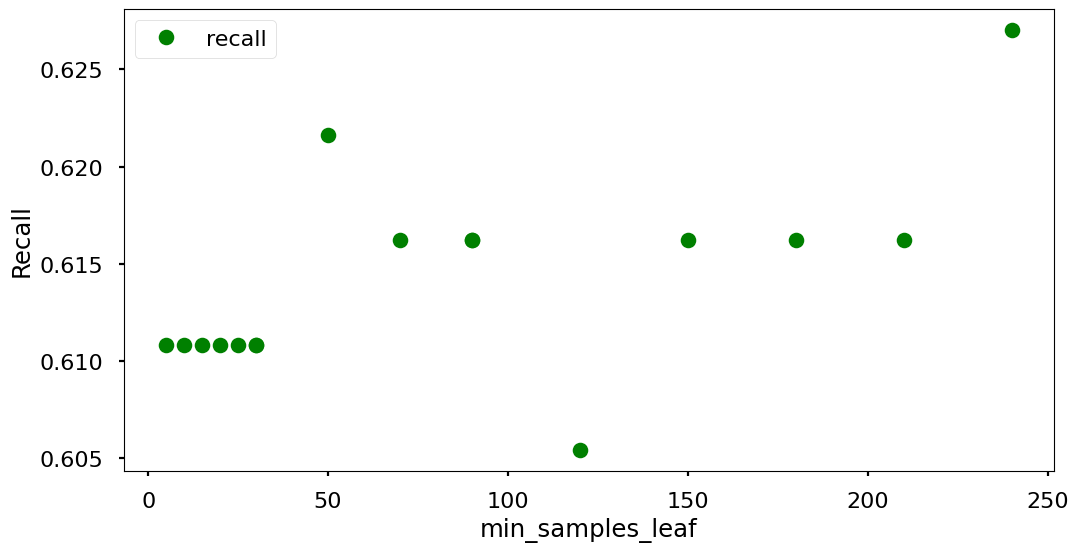

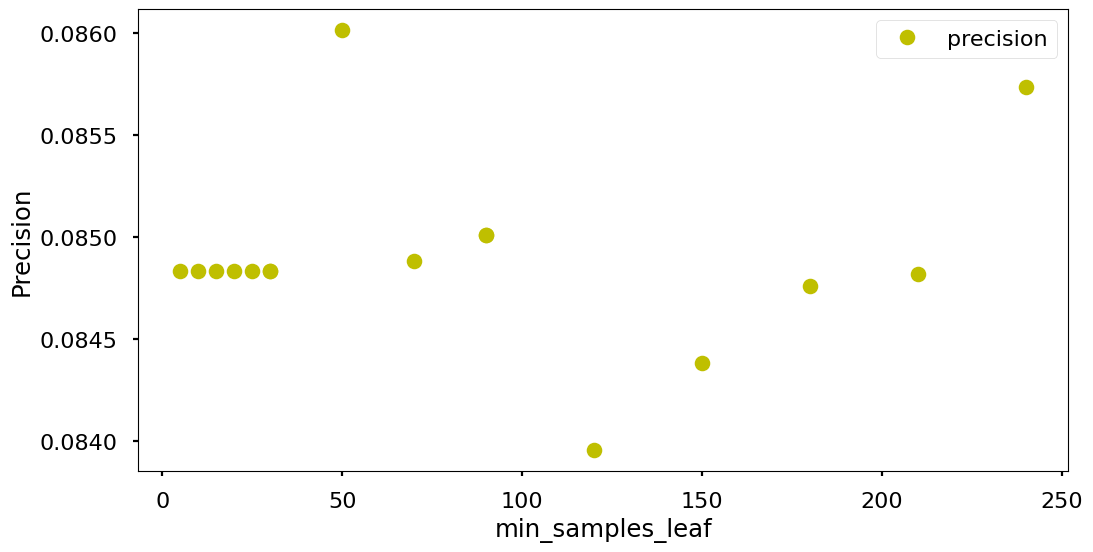

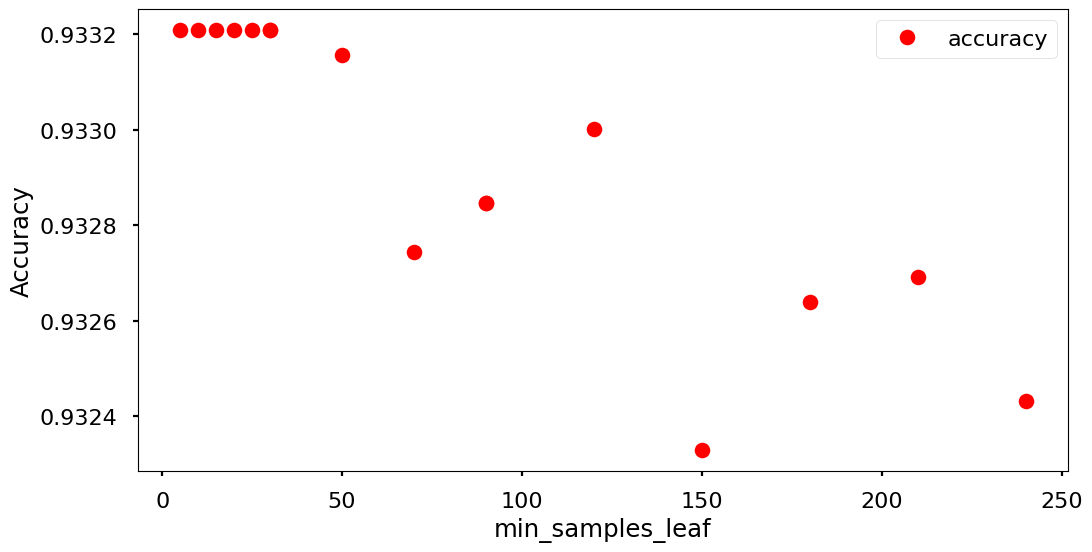

In [72]:
min_samples_leafs =[30,50,70,90]+[5*x for x in range(1,7)]+[90 +30*x for x in range(0,6)]
expected_length = len(min_samples_leafs) # Should be 16

# Slice the results lists to match the expected length
f1_results_plot = f1_results[:expected_length]
recall_results_plot = recall_results[:expected_length]
precision_results_plot = precision_results[:expected_length]
accuracy_results_plot = accuracy_results[:expected_length]


plt.figure(figsize =(12,6))
# Use the sliced list for plotting
plt.plot(min_samples_leafs, f1_results_plot,'bo', label='f1')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1-score')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
# Use the sliced list for plotting
plt.plot(min_samples_leafs, recall_results_plot,'go', label='recall')
plt.xlabel('min_samples_leaf')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
# Use the sliced list for plotting
plt.plot(min_samples_leafs, precision_results_plot,'yo', label='precision')
plt.xlabel('min_samples_leaf')
plt.ylabel('Precision')
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
# Use the sliced list for plotting
plt.plot(min_samples_leafs, accuracy_results_plot,'ro', label = 'accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [74]:
search_min_samples_leaf = pd.DataFrame()
# Make sure min_samples_leafs has the correct length (16) from cell In[78]
expected_length = len(min_samples_leafs)

search_min_samples_leaf['min_samples_leaf']= min_samples_leafs
# Slice the results lists to match the expected length before assignment
search_min_samples_leaf['accuracy']= accuracy_results[:expected_length]
search_min_samples_leaf['f1_score'] =f1_results[:expected_length]
search_min_samples_leaf['recall_score'] = recall_results[:expected_length]

search_min_samples_leaf

,min_samples_leaf,accuracy,f1_score,recall_score
0,30,0.933209,0.148978,0.610811
1,50,0.933157,0.151117,0.621622
2,70,0.932744,0.149215,0.616216
3,90,0.932847,0.149410,0.616216
4,5,0.933209,0.148978,0.610811
5,10,0.933209,0.148978,0.610811
6,15,0.933209,0.148978,0.610811
7,20,0.933209,0.148978,0.610811
8,25,0.933209,0.148978,0.610811
9,30,0.933209,0.148978,0.610811


In [75]:
search_min_samples_leaf.sort_values(by=['recall_score'], inplace = True)

In [76]:
search_min_samples_leaf

,min_samples_leaf,accuracy,f1_score,recall_score
11,120,0.933002,0.147465,0.605405
0,30,0.933209,0.148978,0.610811
4,5,0.933209,0.148978,0.610811
5,10,0.933209,0.148978,0.610811
6,15,0.933209,0.148978,0.610811
7,20,0.933209,0.148978,0.610811
8,25,0.933209,0.148978,0.610811
9,30,0.933209,0.148978,0.610811
2,70,0.932744,0.149215,0.616216
3,90,0.932847,0.149410,0.616216


In [77]:

rndforest_tuning['search_min_samples_leaf'] = search_min_samples_leaf

# Saving the collection of hyperparameters with their evaluation scores to Results dictionary

In [78]:
Results['rndforest_tuning'] = rndforest_tuning

# The baseline cross validation result for the random forest model

In [80]:
forest1 = RandomForestClassifier(max_depth=5, min_samples_split=687)
mean_rf_cv_score1 = np.mean(cross_val_score(forest, X_train, y_train, cv=3))
print("Mean Cross Validation Score for Random Forest Classifier:{:.4}%".format(mean_rf_cv_score1*100))

Mean Cross Validation Score for Random Forest Classifier:90.36%


# The optimization for the random forest model using GridsearchCV

In [82]:
forest_param_grid = {
    'n_estimators':[50,100],
    'criterion':['gini','entropy'],
    'max_depth':[5,7,11],
    'min_samples_split':[534,611,687],
    'min_samples_leaf':[240]
}
forest_grid_search = GridSearchCV(forest, forest_param_grid, cv=3)
forest_grid_search.fit(X_train, y_train)

print("Testing Accuracy: {:.4}%".format(forest_grid_search.best_score_ * 100))
print("Optimal Parameters: {}".format(forest_grid_search.best_params_))

Testing Accuracy: 91.84%
Optimal Parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 240, 'min_samples_split': 534, 'n_estimators': 50}


Model Report

Accuracy :0.9272458381321328
AUC Score (Train):0.9778588228240503
CV Score : Mean - 0.9742518262416817 | Std - 0.0018353489419605 | Min - 0.9713093595421445 | Max - 0.9766699978121421


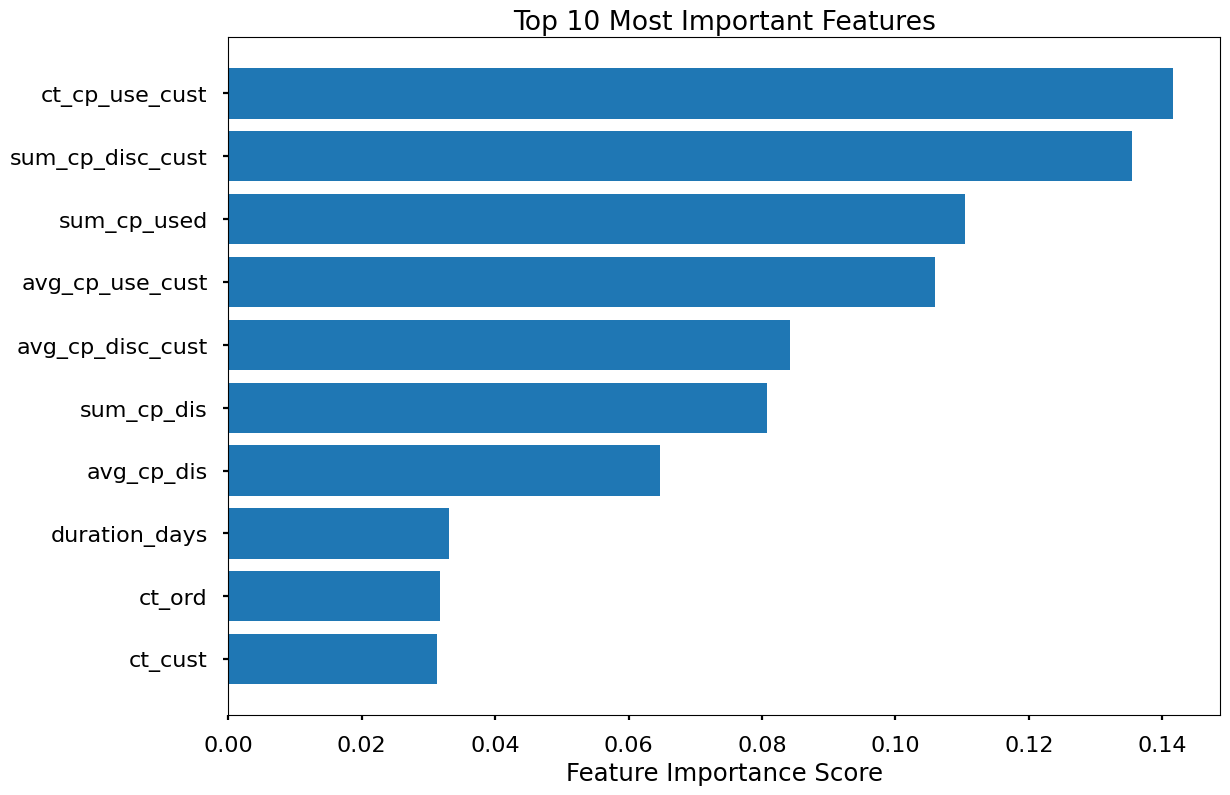

In [84]:
RNDforest = RandomForestClassifier(n_estimators=50,
                                   criterion= 'entropy',
                      max_depth=11,
                      min_samples_split=534,
                      min_samples_leaf=240)
modelfit(RNDforest, X_train, y_train, X_train.columns)

Train set

Precision Score: 0.8591742876777502
Recall Score: 0.8573161725920456
Accuracy Score: 0.9297324887446341
F1 Score: 0.8582442244224422


Test set

Precision Score: 0.10444874274661509
Recall Score: 0.5837837837837838
Accuracy Score: 0.9481090589270009
F1 Score: 0.17719442165709598


Confusion matrix, without normalization
[[18218    77]
 [  926   108]]


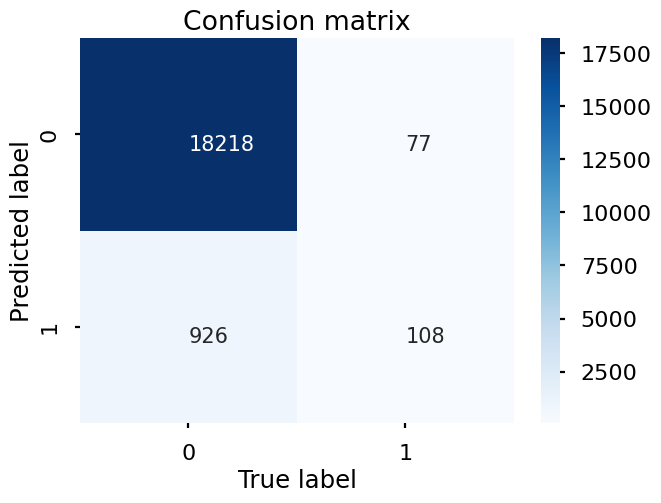

rndforest is saved in Results table.
train_scores dataframe is updated.

                  Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg                  0.620023      0.908482        0.839153  0.737034
RandomForest             1.000000      0.999947        0.999987  0.999974
GradientBoosting         0.888239      0.896719        0.946380  0.892459
rndforest                0.859174      0.857316        0.929732  0.858244


test_scores dataframe is updated.

                  Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg                  0.037766      0.767568        0.810595  0.071990
RandomForest             0.280303      0.200000        0.987428  0.233438
GradientBoosting         0.113043      0.491892        0.958198  0.183838
rndforest                0.104449      0.583784        0.948109  0.177194


In [85]:
rndforest = result()
Saving_results(rndforest,RNDforest,'rndforest')

In [86]:
rndforest_feat_imp = pd.Series(RNDforest.feature_importances_, X_train.columns).sort_values(ascending=False)

In [87]:

Results['rndforest_feat_imp']= rndforest_feat_imp

In [88]:
Results.keys()

dict_keys(['data_sets', 'Log_reg', 'train_scores', 'test_scores', 'RandomForest', 'GradientBoosting', 'LogReg_FtImp', 'rndforest_tuning', 'rndforest', 'rndforest_feat_imp'])

# Gradient Boosting

In [91]:
gradBoost_baseline = GradientBoostingClassifier(max_depth=8,
                                                min_samples_split = 350,#0.05% of observation size
                                                min_samples_leaf = 50,
                                                max_features = 'sqrt',
                                                subsample=0.8,
                                                random_state=123)

In [92]:

gradBoost_baseline.__dict__

{'n_estimators': 100,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'criterion': 'friedman_mse',
 'min_samples_split': 350,
 'min_samples_leaf': 50,
 'min_weight_fraction_leaf': 0.0,
 'subsample': 0.8,
 'max_features': 'sqrt',
 'max_depth': 8,
 'min_impurity_decrease': 0.0,
 'ccp_alpha': 0.0,
 'init': None,
 'random_state': 123,
 'alpha': 0.9,
 'verbose': 0,
 'max_leaf_nodes': None,
 'warm_start': False,
 'validation_fraction': 0.1,
 'n_iter_no_change': None,
 'tol': 0.0001}

Model Report

Accuracy :0.9883127421212439
AUC Score (Train):0.9991189621582075
CV Score : Mean - 0.9979261596816391 | Std - 0.0012965036001891855 | Min - 0.995349365895128 | Max - 0.9987990382390851


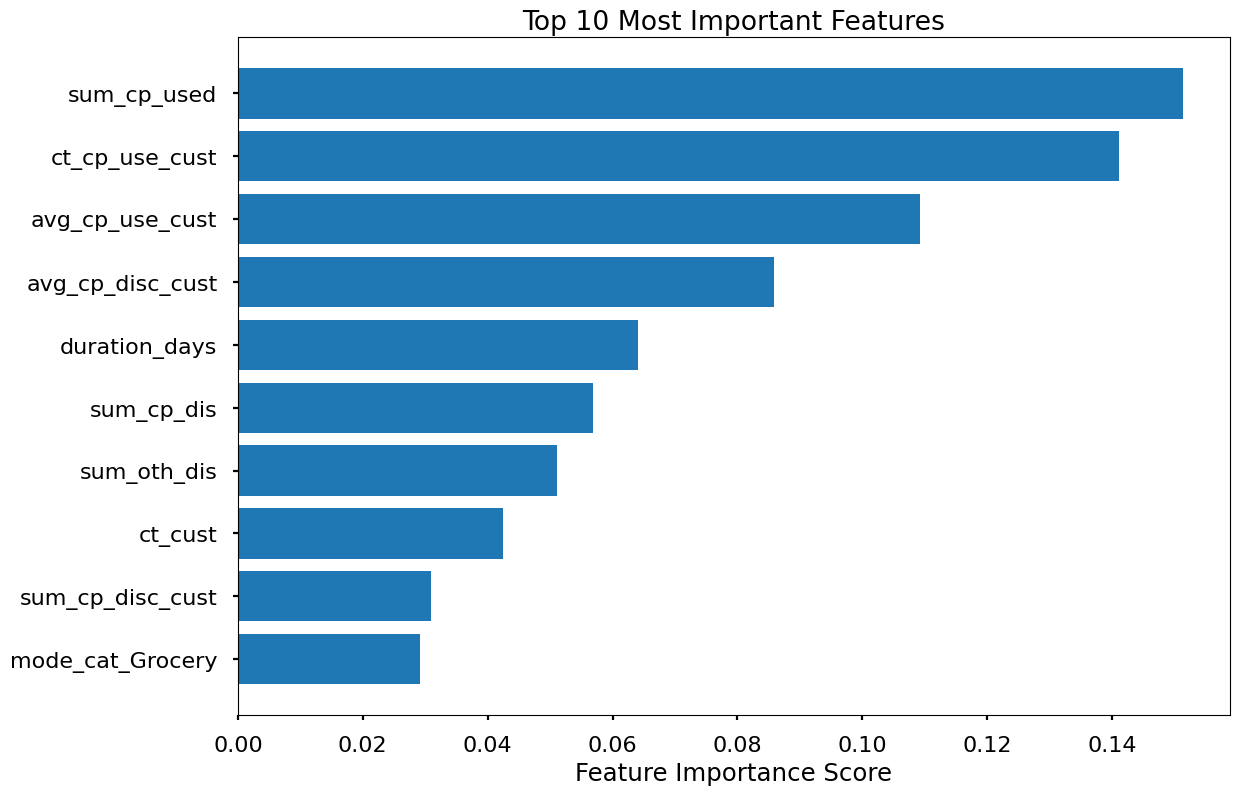

In [93]:

modelfit(gradBoost_baseline, X_train, y_train, X_train.columns)

# Tuning hyperparameters

In [94]:

param_test1 = {'n_estimators':range(20,81,10)}
gridsearch1 = GridSearchCV(estimator= gradBoost_baseline,
                      param_grid= param_test1,
                      scoring = 'recall', 
                      n_jobs= 4,
                       cv=5
                      )
gridsearch1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=350,
                                                  random_state=123,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 81, 10)},
             scoring='recall')

In [95]:
gridsearch1.best_params_, gridsearch1.best_score_

({'n_estimators': 80}, np.float64(0.9678247782055435))

In [96]:

gridsearch1.cv_results_

{'mean_fit_time': array([1.62440524, 2.32333493, 3.05741739, 4.02708311, 5.02596674,
        5.31296134, 5.95678477]),
 'std_fit_time': array([0.04389251, 0.02045327, 0.03055595, 0.08220782, 0.25055535,
        0.03020827, 0.19273306]),
 'mean_score_time': array([0.01415181, 0.01741929, 0.0204423 , 0.02534366, 0.0289793 ,
        0.03149142, 0.03369436]),
 'std_score_time': array([0.00134443, 0.00129458, 0.00107276, 0.00105107, 0.00216872,
        0.00039896, 0.00159895]),
 'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
              mask=[False, False, False, False, False, False, False],
        fill_value=999999),
 'params': [{'n_estimators': 20},
  {'n_estimators': 30},
  {'n_estimators': 40},
  {'n_estimators': 50},
  {'n_estimators': 60},
  {'n_estimators': 70},
  {'n_estimators': 80}],
 'split0_test_score': array([0.86234177, 0.89293249, 0.90163502, 0.90981013, 0.91719409,
        0.91877637, 0.92035865]),
 'split1_test_score': array([0.90743671, 0.94224684

In [97]:
param_test2 = {'max_depth':range(5,16,2), 
              'min_samples_split': range(200,1001, 200),
              'n_estimators':[80]}
gridsearch2 = GridSearchCV(estimator=gradBoost_baseline,
                          param_grid= param_test2,
                          scoring= 'recall',
                          n_jobs =4,
                          cv = 5)
gridsearch2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=350,
                                                  random_state=123,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 1001, 200),
                         'n_estimators': [80]},
             scoring='recall')

In [98]:
gridsearch2.best_params_, gridsearch2.best_score_

({'max_depth': 15, 'min_samples_split': 200, 'n_estimators': 80},
 np.float64(0.983227388985906))

In [99]:
gridsearch2.cv_results_

{'mean_fit_time': array([ 4.49637685,  4.76348948,  4.62228274,  4.66259441,  4.32151465,
         5.849231  ,  5.59476223,  5.54654822,  5.49838357,  5.49875135,
         7.24468942,  7.19998393,  7.06030493,  6.95792665,  7.01703644,
         9.20393753,  9.22760959,  9.28537092,  9.39509306, 10.81430602,
        13.71223893, 12.97895484, 12.29137721, 11.42381363, 11.56042242,
        14.14811702, 13.30078816, 12.59994936, 12.21131902, 10.71811724]),
 'std_fit_time': array([0.22732297, 0.17441558, 0.05884097, 0.01293468, 0.06592747,
        0.16152573, 0.04043325, 0.01212472, 0.04747769, 0.02457637,
        0.06016115, 0.03906353, 0.07782931, 0.09668586, 0.07402483,
        0.08150897, 0.10069858, 0.10436692, 0.05922994, 0.73054274,
        0.11115809, 0.21026639, 0.17959296, 0.11615824, 0.13642504,
        0.12752989, 0.050204  , 0.13675302, 0.46724089, 1.36771054]),
 'mean_score_time': array([0.02722602, 0.02452035, 0.02402353, 0.02653637, 0.02429519,
        0.03292098, 0.03208585

In [100]:
param_test3 = {'min_samples_leaf':range(30,71,10), 
              'min_samples_split': range(40,201,40)}
gridsearch3 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate = 0.1,
                                                                n_estimators=80,
                                                                max_depth=15,
                                                                min_samples_split = 200,
                                                                max_features = 'sqrt',
                                                                subsample=0.8,
                                                                random_state=123),
                          param_grid= param_test3,
                          scoring= 'recall',
                          n_jobs =4,
                          cv = 5)
gridsearch3.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=15,
                                                  max_features='sqrt',
                                                  min_samples_split=200,
                                                  n_estimators=80,
                                                  random_state=123,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'min_samples_leaf': range(30, 71, 10),
                         'min_samples_split': range(40, 201, 40)},
             scoring='recall')

In [101]:
gridsearch3.best_params_, gridsearch2.best_score_

({'min_samples_leaf': 40, 'min_samples_split': 40},
 np.float64(0.983227388985906))

In [102]:

gridsearch3.cv_results_

{'mean_fit_time': array([11.90353236, 11.80191822, 13.24528618, 15.29401183, 16.00789046,
        16.71190839, 16.56023164, 15.28873739, 14.86309123, 14.45120969,
        14.11971307, 14.04397721, 14.27899861, 14.43553486, 13.79480577,
        13.92812638, 14.55082951, 14.28317957, 14.17354879, 13.90924931,
        14.08462257, 14.5910542 , 14.86520991, 14.26861587, 13.12628398]),
 'std_fit_time': array([0.07716623, 0.37204271, 1.15202726, 0.69407391, 0.13665728,
        0.37258129, 0.21557544, 0.51527243, 0.06829976, 0.67995675,
        0.1755908 , 0.03061532, 0.28108996, 0.4838971 , 0.16949289,
        0.29495198, 0.12401645, 0.14175839, 0.2790821 , 0.15061234,
        0.07557389, 0.45699814, 0.31262736, 0.14413934, 1.83881485]),
 'mean_score_time': array([0.07426291, 0.07262864, 0.09058905, 0.09563336, 0.11233745,
        0.09888859, 0.0950798 , 0.09278402, 0.10591464, 0.08329387,
        0.08547959, 0.08542638, 0.13155189, 0.0830183 , 0.08345232,
        0.08754301, 0.08712978, 0.0

Model Report

Accuracy :0.9988875510417757
AUC Score (Train):0.9999921341399536


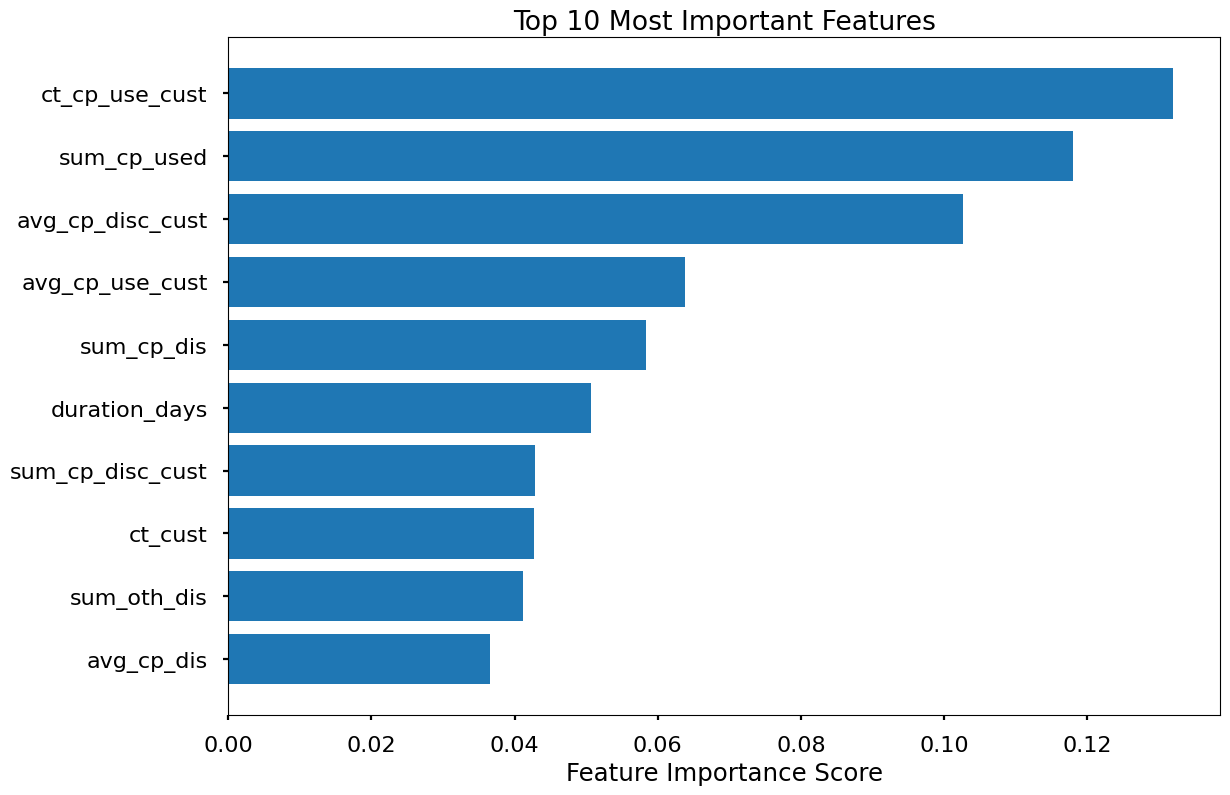

In [103]:
GR_Boost = GradientBoostingClassifier(learning_rate = 0.1,
                            n_estimators=80,
                            max_depth=15,
                            max_features = 'sqrt',
                            subsample=0.8,
                            min_samples_split=120,
                            min_samples_leaf=30,
                            random_state=123)
modelfit(GR_Boost, X_train, y_train, X_train.columns, performCV=False)

Train set

Precision Score: 0.9975220119154321
Recall Score: 0.9979955691528642
Accuracy Score: 0.9988875510417757
F1 Score: 0.9977587343441002


Test set

Precision Score: 0.291970802919708
Recall Score: 0.21621621621621623
Accuracy Score: 0.9874799524031248
F1 Score: 0.2484472049689441


Confusion matrix, without normalization
[[19047   145]
 [   97    40]]


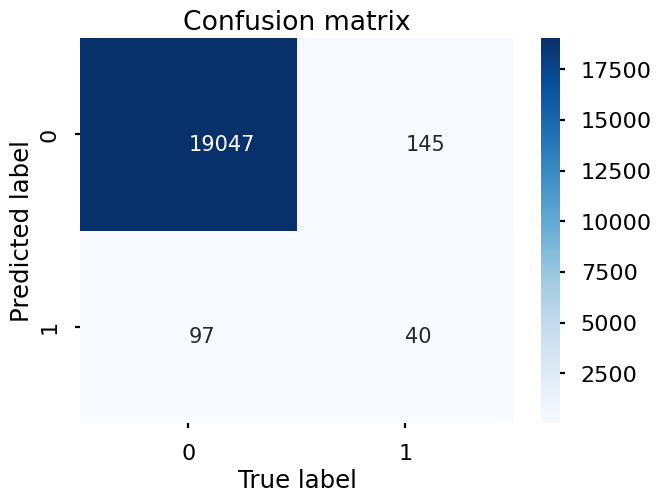

gradBoost is saved in Results table.
train_scores dataframe is updated.

                  Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg                  0.620023      0.908482        0.839153  0.737034
RandomForest             1.000000      0.999947        0.999987  0.999974
GradientBoosting         0.888239      0.896719        0.946380  0.892459
rndforest                0.859174      0.857316        0.929732  0.858244
gradBoost                0.997522      0.997996        0.998888  0.997759


test_scores dataframe is updated.

                  Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg                  0.037766      0.767568        0.810595  0.071990
RandomForest             0.280303      0.200000        0.987428  0.233438
GradientBoosting         0.113043      0.491892        0.958198  0.183838
rndforest                0.104449      0.583784        0.948109  0.177194
gradBoost                0.291971      0.216216        0.987480  0.248447


In [104]:

# Saving_results(result_obj, md_obj,result_name)
gradBoost = result()
Saving_results(gradBoost,GR_Boost,'gradBoost')

In [106]:

grd_boost4 = GradientBoostingClassifier(learning_rate = 0.1,
                            n_estimators=80,
                            max_depth=15,
                            max_features = 'sqrt',
                            subsample=0.8,
                            min_samples_split=120,
                            min_samples_leaf=30,
                            random_state=123)
param_test4 = {'subsample':[0.6+0.05*x for x in range(0,7)]}
gridsearch4 = GridSearchCV(estimator=grd_boost4,
                           param_grid= param_test4,
                           scoring='recall',
                           n_jobs=4,
                           # iid=False,  # Remove this argument
                           cv=5)
gridsearch4.fit(X_train,y_train)
gridsearch4.best_params_, gridsearch4.best_score_

({'subsample': 0.85}, np.float64(0.9843879491400352))

Model Report

Accuracy :0.9991885666422364
AUC Score (Train):0.9999957562734756
CV Score : Mean - 0.9994809079652262 | Std - 0.0006812786282565308 | Min - 0.9981215894026358 | Max - 0.9998837045972833


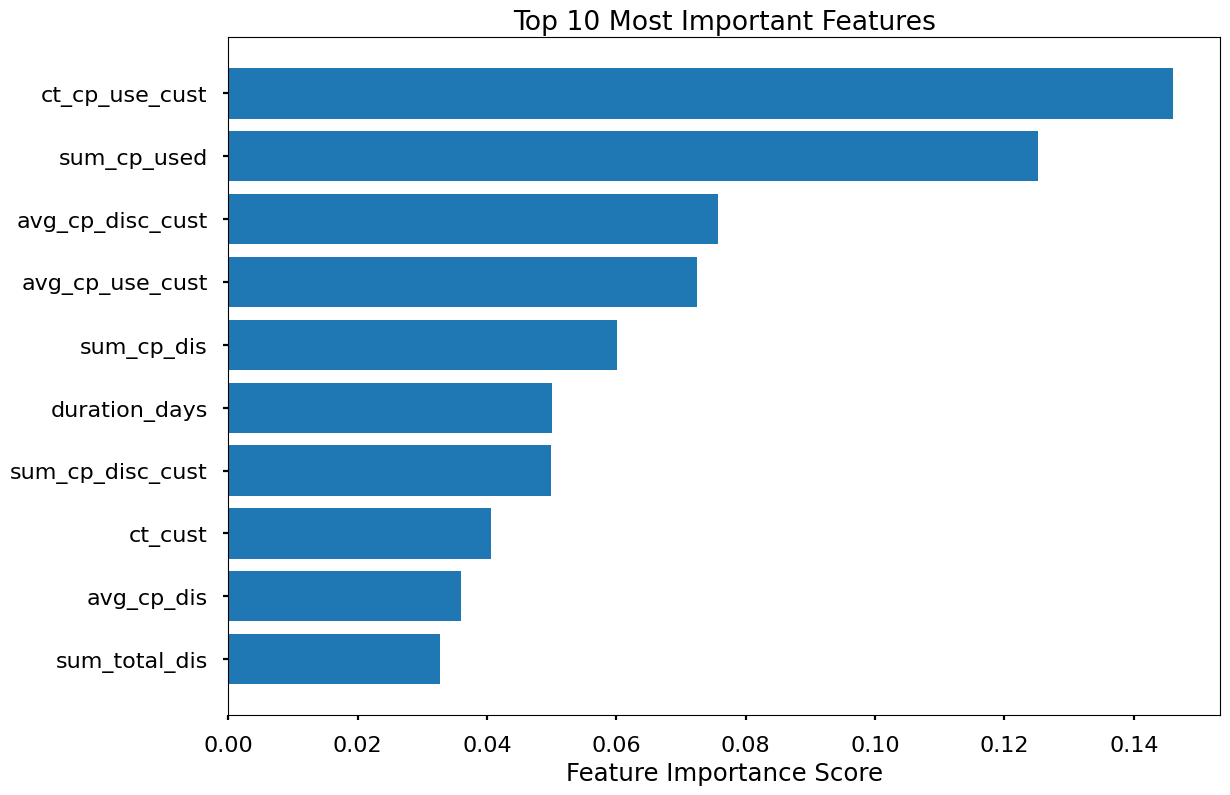

In [107]:
grd_boost4 = GradientBoostingClassifier(learning_rate = 0.05,
                            n_estimators=160,
                            max_depth=15,
                            max_features = 'sqrt',
                            subsample=0.8,
                            min_samples_split=120,
                            min_samples_leaf=30,
                            random_state=123)
modelfit(grd_boost4,X_train,y_train, X_train.columns)

# Saving the model result in Results dictionary

Train set

Precision Score: 0.9982596772492354
Recall Score: 0.9984703027745543
Accuracy Score: 0.9991885666422364
F1 Score: 0.9983649789029536


Test set

Precision Score: 0.2803030303030303
Recall Score: 0.2
Accuracy Score: 0.9874282166692534
F1 Score: 0.2334384858044164


Confusion matrix, without normalization
[[19049   148]
 [   95    37]]


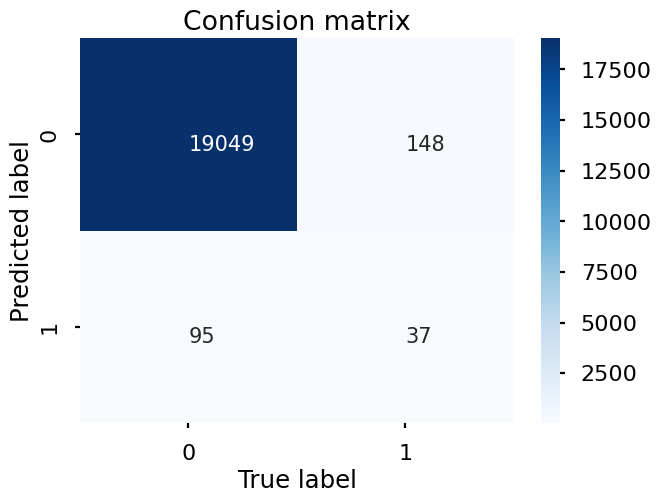

gradBoost is saved in Results table.
train_scores dataframe is updated.

                  Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg                  0.620023      0.908482        0.839153  0.737034
RandomForest             1.000000      0.999947        0.999987  0.999974
GradientBoosting         0.888239      0.896719        0.946380  0.892459
rndforest                0.859174      0.857316        0.929732  0.858244
gradBoost                0.998260      0.998470        0.999189  0.998365


test_scores dataframe is updated.

                  Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg                  0.037766      0.767568        0.810595  0.071990
RandomForest             0.280303      0.200000        0.987428  0.233438
GradientBoosting         0.113043      0.491892        0.958198  0.183838
rndforest                0.104449      0.583784        0.948109  0.177194
gradBoost                0.280303      0.200000        0.987428  0.233438


In [108]:
# Saving_results(result_obj, md_obj,result_name)
gradBoost = result()
Saving_results(gradBoost,grd_boost4,'gradBoost')

In [109]:
gradBoost_feat_imp = pd.Series(grd_boost4.feature_importances_, X_train.columns).sort_values(ascending=False)

In [110]:
Results['gradBoost_feat_imp']=gradBoost_feat_imp

# XGBoost Model 


--- Running XGBoost ---


/Users/kiranbele/Downloads/Predicting_Coupon_Redemption_ML/cpenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train set

Precision Score: 0.9253095189770651
Recall Score: 0.9619158139044203
Accuracy Score: 0.9712857292430112
F1 Score: 0.9432576423731444


Test set

Precision Score: 0.13355048859934854
Recall Score: 0.44324324324324327
Accuracy Score: 0.9671478089916705
F1 Score: 0.20525657071339173


Confusion matrix, without normalization
[[18612   103]
 [  532    82]]


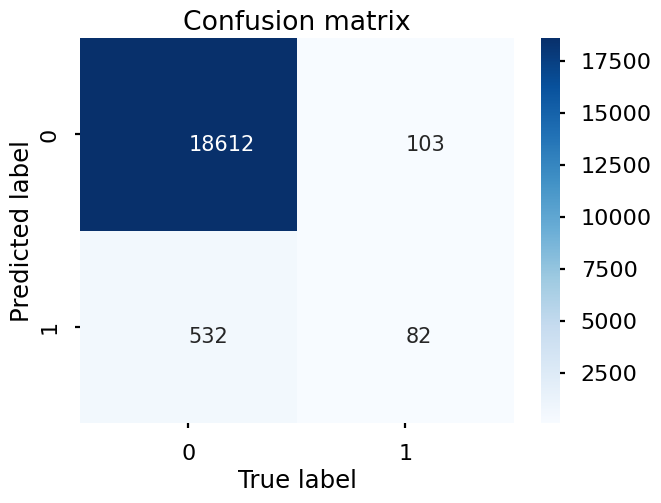

XGBoost is saved in Results table.
train_scores dataframe is updated.

                  Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg                  0.620023      0.908482        0.839153  0.737034
RandomForest             1.000000      0.999947        0.999987  0.999974
GradientBoosting         0.888239      0.896719        0.946380  0.892459
rndforest                0.859174      0.857316        0.929732  0.858244
gradBoost                0.998260      0.998470        0.999189  0.998365
XGBoost                  0.925310      0.961916        0.971286  0.943258


test_scores dataframe is updated.

                  Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg                  0.037766      0.767568        0.810595  0.071990
RandomForest             0.280303      0.200000        0.987428  0.233438
GradientBoosting         0.113043      0.491892        0.958198  0.183838
rndforest                0.104449      0.583784        0.948109  0.177194
grad

In [111]:


print("\n--- Running XGBoost ---")

# Create a result object for XGBoost
XGB_result = result()

# Instantiate the XGBoost Classifier
# Common parameters:
# n_estimators: Number of boosting rounds (trees)
# learning_rate: Step size shrinkage to prevent overfitting
# max_depth: Maximum depth of a tree
# subsample: Fraction of samples used for fitting the individual base learners
# colsample_bytree: Fraction of features used for fitting the individual base learners
# objective='binary:logistic': For binary classification
# eval_metric='logloss' or 'auc': Metric used for evaluation on validation sets (if used)
# use_label_encoder=False: Recommended to avoid potential issues/warnings
# random_state: For reproducibility
xgb_model = xgb.XGBClassifier(
    n_estimators=100,          # Start with 100, can be tuned
    learning_rate=0.1,         # Common starting point
    max_depth=5,               # Similar to other models, can be tuned
    subsample=0.8,             # Typical value
    colsample_bytree=0.8,      # Typical value
    objective='binary:logistic',
    eval_metric='logloss',     # Or 'auc'
    use_label_encoder=False,   # Recommended setting
    random_state=123           # Use the same random state as other models
)

# Use the existing function to train, evaluate, and save results
# Make sure X_train, y_train, X_test, y_test are available in the scope
Saving_results(XGB_result, xgb_model, 'XGBoost')

# Optional: Add the results object to your main Results dictionary if you have one
# Results['XGBoost_result_obj'] = XGB_result # Example name

print("\n--- XGBoost Run Complete ---")


# Aggregating results (predictions) of three models

In [112]:
# In[118] # Or the appropriate cell number

# Aggregating results (predictions) of four models
test = (rndforest.preds['test_preds'] +
        gradBoost.preds['test_preds'] +
        Log_reg.preds['test_preds'] +
        XGB_result.preds['test_preds']) 

# Explanation of the summed 'test' values:
# if value = 4: All 4 models agree that it is predicted a positive class (1)
# if value = 3: Three models predict positive (1), one predicts negative (0)
# if value = 2: Two models predict positive (1), two predict negative (0)
# if value = 1: One model predicts positive (1), three predict negative (0)
# if value = 0: All 4 models agree that it is predicted a negative class (0)

# You can then use this 'test' array for further analysis,
# like setting a threshold (e.g., predict 1 if test >= 3)

In [113]:
sum(test>2)

np.int64(473)

In [114]:
def avg(n):
    #change the sum value to binary using average value 
    if 1/3*n>0.5:
        return 1
    else:
        return 0

avg_preds = map(avg, test)

In [115]:
agg_preds =pd.Series(avg_preds)

Confusion matrix, without normalization
[[18225    76]
 [  919   109]]


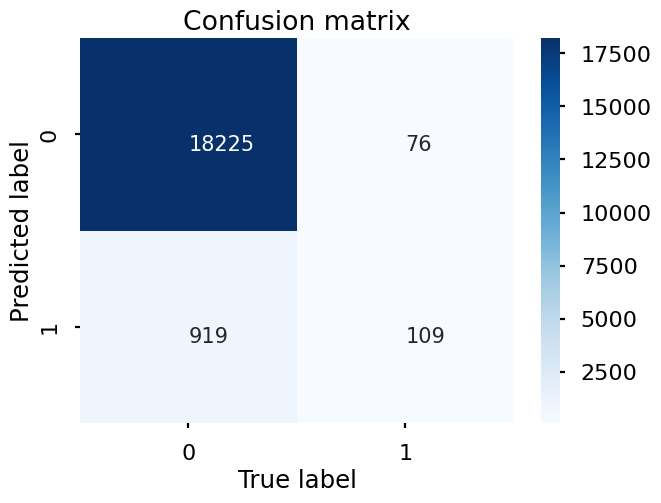

In [116]:
agg_preds_cm = plot_confusion_matrix(agg_preds)

In [117]:
acc=(confusion_matrix(y_test,agg_preds)[0][0]+confusion_matrix(y_test,agg_preds)[1][1])/len(y_test)*100
print('{}% accuracy'.format(round(acc,2)))

94.85% accuracy


In [118]:
rndforest.__dict__['confMat']

array([[18218,    77],
       [  926,   108]])

In [119]:
gradBoost.__dict__['confMat']

array([[19049,   148],
       [   95,    37]])

In [120]:

Log_reg.__dict__['confMat']

array([[15526,    43],
       [ 3618,   142]])

In [121]:
XGB_result.__dict__['confMat']

array([[18612,   103],
       [  532,    82]])

In [122]:
Results['agg_preds']= agg_preds

# Analyzing model results

In [126]:

# Define the list to match the CURRENT rows in train_scores
model_names = [
    'LogisticRegression', # Initial run
    'RandomForest',       # Initial run
    'GradientBoosting',   # Initial run
    'Log_reg',            # Specific C run
    'rndforest',          # Tuned RF run
    'gradBoost'           # Tuned GB run
]

# If you have ALSO run and saved XGBoost BEFORE cell In[132], add it:
model_names.append('XGBoost')

# Optional: print to verify
print(f"Model names list has {len(model_names)} items.")
print(model_names)


Model names list has 7 items.
['LogisticRegression', 'RandomForest', 'GradientBoosting', 'Log_reg', 'rndforest', 'gradBoost', 'XGBoost']


In [132]:
# In[132] # Or the appropriate cell number

# Evaluate models and collect results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported if not already in this cell

# Access the fitted model variables directly
# These variables hold the models fitted by modelfit or Saving_results calls
# Using the variables for the specific/tuned models where available
models = {
    'Logistic Regression': logreg,       # Use the variable holding the fitted LogReg model (from In[37])
    'Random Forest': RNDforest,          # Use the variable holding the tuned RF model (from In[89])
    'Gradient Boosting': grd_boost4,     # Use the variable holding the latest tuned GB model (from In[111])
    'XGBoost': xgb_model                 # Use the variable holding the fitted XGBoost model (from In[117])
}

results = []

# Check if y_test exists, otherwise load/define it
# if 'y_test' not in locals():
#    y_test = datas['y_test'] # Assuming y_test is in your loaded 'datas' dictionary

for name, model in models.items():
    # Ensure X_test is available in the scope
    # if 'X_test' not in locals():
    #    X_test = datas['X_test'] # Assuming X_test is in your loaded 'datas' dictionary

    # Check if the model object actually exists and is fitted
    if hasattr(model, 'predict'):
        try:
            y_pred = model.predict(X_test)
            results.append({
                'Model': name,
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
                'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
                'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
            })
            print(f"Processed: {name}") # Add print statement for debugging
        except Exception as e:
            print(f"Error processing model {name}: {e}")
            # Optionally add placeholder results or skip
            results.append({'Model': name, 'Accuracy': None, 'Precision': None, 'Recall': None, 'F1 Score': f"Error: {e}"})
    else:
        print(f"Model object for {name} not found or doesn't have a predict method.")
        # Optionally add placeholder results or skip
        results.append({'Model': name, 'Accuracy': None, 'Precision': None, 'Recall': None, 'F1 Score': "Model not found/fitted"})


results_df = pd.DataFrame(results)
results_df

Processed: Logistic Regression
Processed: Random Forest
Processed: Gradient Boosting
Processed: XGBoost


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.810595,0.988055,0.810595,0.886663
1,Random Forest,0.948109,0.987260,0.948109,0.965591
2,Gradient Boosting,0.987428,0.985476,0.987428,0.986386
3,XGBoost,0.967148,0.986256,0.967148,0.975781


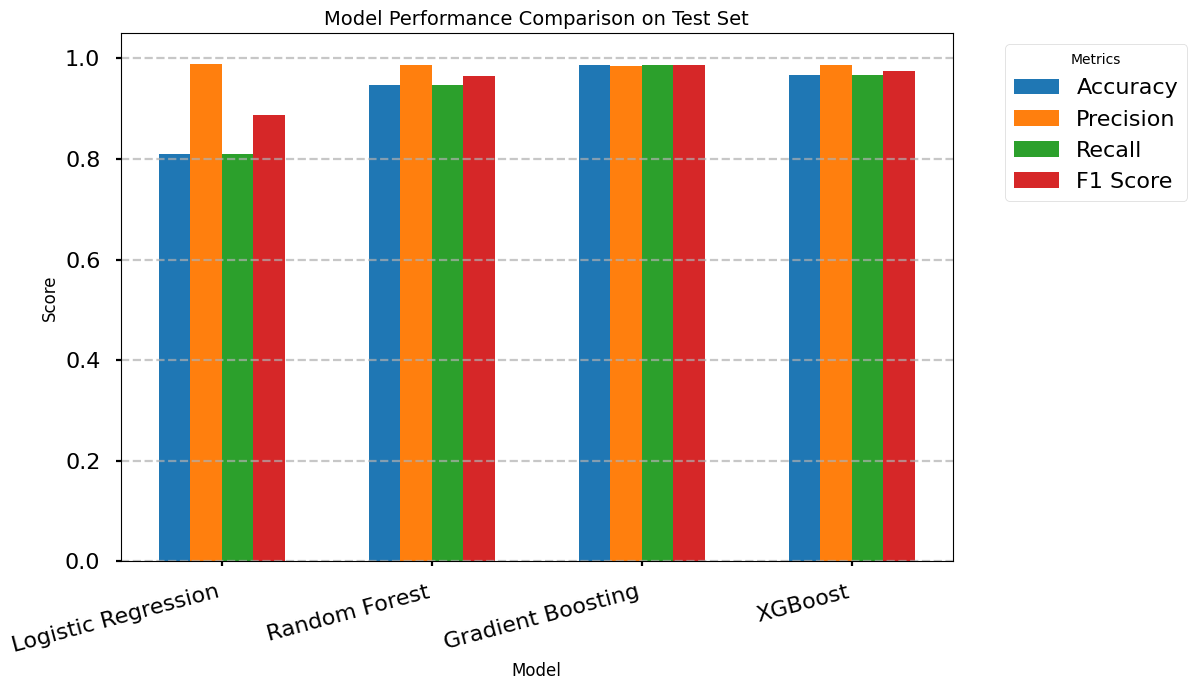

In [133]:


# --- Visualize Model Comparison ---

# Ensure results_df exists and has the data from the previous cell
if 'results_df' in locals() and not results_df.empty:
    # Set the 'Model' column as the index for easier plotting
    plot_df = results_df.set_index('Model')

    # Define the metrics to plot
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    plot_df = plot_df[metrics_to_plot] # Ensure only these columns are plotted

    # Number of models and metrics
    n_models = len(plot_df.index)
    n_metrics = len(plot_df.columns)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 7)) # Adjust figure size as needed

    bar_width = 0.15 # Width of each bar
    index = np.arange(n_models) # x locations for the groups

    # Plot bars for each metric
    for i, metric in enumerate(metrics_to_plot):
        bar_positions = index + i * bar_width
        ax.bar(bar_positions, plot_df[metric], bar_width, label=metric)

    # Add labels, title, and legend
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Model Performance Comparison on Test Set', fontsize=14)
    ax.set_xticks(index + bar_width * (n_metrics - 1) / 2) # Center x-ticks under the groups
    ax.set_xticklabels(plot_df.index, rotation=15, ha='right') # Rotate labels if needed
    ax.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside plot
    ax.grid(axis='y', linestyle='--', alpha=0.7) # Add horizontal grid lines
    ax.set_ylim(0, 1.05) # Set y-axis limits (adjust if needed, e.g., if focusing on higher scores)

    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

else:
    print("results_df not found or is empty. Please run the previous cell first.")
